In [1]:
import os
from typing import Optional, Tuple, List, Union, Callable

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import trange

# For repeatability
# seed = 3407
# torch.manual_seed(seed)
# np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# FROM GAN_stability https://github.com/LMescheder/GAN_stability/blob/master/gan_training/config.py

import yaml
from torch import optim
from os import path

# General config
def load_config(path, default_path):
    ''' Loads config file.
    Args:  
        path (str): path to config file
        default_path (bool): whether to use default path
    '''
    # Load configuration from file itself
    with open(path, 'r') as f:
        # cfg_special = yaml.load(f)
        cfg_special = yaml.safe_load(f)

    # Check if we should inherit from a config
    inherit_from = cfg_special.get('inherit_from')

    # If yes, load this config first as default
    # If no, use the default_path
    if inherit_from is not None:
        cfg = load_config(inherit_from, default_path)
    elif default_path is not None:
        with open(default_path, 'r') as f:
            # cfg = yaml.load(f)
            cfg = yaml.safe_load(f)
    else:
        cfg = dict()

    # Include main configuration
    update_recursive(cfg, cfg_special)

    return cfg


def update_recursive(dict1, dict2):
    ''' Update two config dictionaries recursively.
    Args:
        dict1 (dict): first dictionary to be updated
        dict2 (dict): second dictionary which entries should be used
    '''
    for k, v in dict2.items():
        # Add item if not yet in dict1
        if k not in dict1:
            dict1[k] = None
        # Update
        if isinstance(dict1[k], dict):
            update_recursive(dict1[k], v)
        else:
            dict1[k] = v

In [3]:
import glob
import numpy as np
from PIL import Image

from torchvision.datasets.vision import VisionDataset


class ImageDataset(VisionDataset):
    """
    Load images from multiple data directories.
    Folder structure: data_dir/filename.png
    """

    def __init__(self, data_dirs, transforms=None):
#         print("****************************")
#         print("INIT")
#         print("****************************")
        # Use multiple root folders
        if not isinstance(data_dirs, list):
            data_dirs = [data_dirs]

        # initialize base class
        VisionDataset.__init__(self, root=data_dirs, transform=transforms)

        self.filenames = []
        root = []
        # print(self.root)
        for ddir in self.root:
            filenames = self._get_files(ddir)
            self.filenames.extend(filenames)
            root.append(ddir)
#         print("FILENAMES")
        # print(self.filenames)
#         print("****************************")
        self.filenames.sort()

    def __len__(self):
        return len(self.filenames)

    @staticmethod
    def _get_files(root_dir):
        return glob.glob(f'{root_dir}/*.png') + glob.glob(f'{root_dir}/*.jpg')

    def __getitem__(self, idx):
#         print("************************")
#         print("GET_ITEM")
        filename = self.filenames[idx]
        # print(self.filenames)
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
#         print("************************")
        return img


class DRR(ImageDataset):
    def __init__(self, *args, **kwargs):
        super(DRR, self).__init__(*args, **kwargs)


class Carla(ImageDataset):
    def __init__(self, *args, **kwargs):
        super(Carla, self).__init__(*args, **kwargs)


class CelebA(ImageDataset):
    def __init__(self, *args, **kwargs):
        super(CelebA, self).__init__(*args, **kwargs)


class CUB(ImageDataset):
    def __init__(self, *args, **kwargs):
        super(CUB, self).__init__(*args, **kwargs)
        

class Cats(ImageDataset):
    def __init__(self, *args, **kwargs):
      super(Cats, self).__init__(*args, **kwargs)
    
    @staticmethod
    def _get_files(root_dir):
      return glob.glob(f'{root_dir}/CAT_*/*.jpg')


class CelebAHQ(ImageDataset):
    def __init__(self, *args, **kwargs):
        super(CelebAHQ, self).__init__(*args, **kwargs)
    
    def _get_files(self, root):
        return glob.glob(f'{root}/*.npy')
    
    def __getitem__(self, idx):
        img = np.load(self.filenames[idx]).squeeze(0).transpose(1,2,0)
        if img.dtype == np.uint8:
            pass
        elif img.dtype == np.float32:
            img = (img * 255).astype(np.uint8)
        else:
            raise NotImplementedError
        img = Image.fromarray(img).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        return img

In [4]:
import numpy as np
import torch
import imageio
import os
import glob
from torch.utils import data
from torch.utils.data import Dataset
from PIL import Image


class  ImageFolder(Dataset):
    """docstring for ArtDataset"""
    def __init__(self, root, transform=None):
        super( ImageFolder, self).__init__()
        self.root = root

        self.frame = self._parse_frame()
        self.transform = transform

    def _parse_frame(self):
        frame = []
        folders = glob.glob(os.path.join(self.root, '*'))
        for folder in folders:
            for f in glob.glob(os.path.join(folder, '*.png')):
                frame.append(f)
        return frame

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        file = self.frame[idx]
        img = Image.open(file).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img

def InfiniteSampler(n):
    """Data sampler"""
    i = n - 1
    order = np.random.permutation(n)
    while True:
        yield order[i]
        i += 1
        if i >= n:
            np.random.seed()
            order = np.random.permutation(n)
            i = 0

class InfiniteSamplerWrapper(data.sampler.Sampler):
    """Data sampler wrapper"""
    def __init__(self, data_source):
        self.num_samples = len(data_source)

    def __iter__(self):
        return iter(InfiniteSampler(self.num_samples))

    def __len__(self):
        return 2 ** 15

def get_nsamples(data_loader, N):
  x = []
  n = 0
  while n < N:
    x_next = next(data_loader)
    x_next = x_next.cuda(non_blocking=True)
    x.append(x_next)
    n += x_next.size(0)
  x = torch.cat(x, dim=0)[:N]
  return x


def count_trainable_parameters(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  return sum([np.prod(p.size()) for p in model_parameters])


def save_video(imgs, fname, as_gif=False, fps=24, quality=8):
    # convert to np.uint8
    imgs = (255 * np.clip(imgs.permute(0, 2, 3, 1).detach().cpu().numpy() / 2 + 0.5, 0, 1)).astype(np.uint8)
    imageio.mimwrite(fname, imgs, fps=fps, quality=quality)
    
    if as_gif:  # save as gif, too
        os.system(f'ffmpeg -i {fname} -r 15 '
                  f'-vf "scale=512:-1,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" {os.path.splitext(fname)[0] + ".gif"}')


def color_depth_map(depths, scale=None):
    """
    Color an input depth map.
    Arguments:
        depths -- HxW numpy array of depths
        [scale=None] -- scaling the values (defaults to the maximum depth)
    Returns:
        colored_depths -- HxWx3 numpy array visualizing the depths
    """

    _color_map_depths = np.array([
      [0, 0, 0],  # 0.000
      [0, 0, 255],  # 0.114
      [255, 0, 0],  # 0.299
      [255, 0, 255],  # 0.413
      [0, 255, 0],  # 0.587
      [0, 255, 255],  # 0.701
      [255, 255, 0],  # 0.886
      [255, 255, 255],  # 1.000
      [255, 255, 255],  # 1.000
    ]).astype(float)
    _color_map_bincenters = np.array([
      0.0,
      0.114,
      0.299,
      0.413,
      0.587,
      0.701,
      0.886,
      1.000,
      2.000,  # doesn't make a difference, just strictly higher than 1
    ])
  
    if scale is None:
      scale = depths.max()
  
    values = np.clip(depths.flatten() / scale, 0, 1)
    # for each value, figure out where they fit in in the bincenters: what is the last bincenter smaller than this value?
    lower_bin = ((values.reshape(-1, 1) >= _color_map_bincenters.reshape(1, -1)) * np.arange(0, 9)).max(axis=1)
    lower_bin_value = _color_map_bincenters[lower_bin]
    higher_bin_value = _color_map_bincenters[lower_bin + 1]
    alphas = (values - lower_bin_value) / (higher_bin_value - lower_bin_value)
    colors = _color_map_depths[lower_bin] * (1 - alphas).reshape(-1, 1) + _color_map_depths[
      lower_bin + 1] * alphas.reshape(-1, 1)
    return colors.reshape(depths.shape[0], depths.shape[1], 3).astype(np.uint8)


# Virtual camera utils


def to_sphere(u, v):
    theta = 2 * np.pi * u
    phi = np.arccos(1 - 2 * v)
    cx = np.sin(phi) * np.cos(theta)
    cy = np.sin(phi) * np.sin(theta)
    cz = np.cos(phi)
    s = np.stack([cx, cy, cz])
    return s


def polar_to_cartesian(r, theta, phi, deg=True):
    if deg:
        phi = phi * np.pi / 180
        theta = theta * np.pi / 180
    cx = np.sin(phi) * np.cos(theta)
    cy = np.sin(phi) * np.sin(theta)
    cz = np.cos(phi)
    return r * np.stack([cx, cy, cz])


def to_uv(loc):
    # normalize to unit sphere
    loc = loc / loc.norm(dim=1, keepdim=True)

    cx, cy, cz = loc.t()
    v = (1 - cz) / 2

    phi = torch.acos(cz)
    sin_phi = torch.sin(phi)

    # ensure we do not divide by zero
    eps = 1e-8
    sin_phi[sin_phi.abs() < eps] = eps

    theta = torch.acos(cx / sin_phi)

    # check for sign of phi
    cx_rec = sin_phi * torch.cos(theta)
    if not np.isclose(cx.numpy(), cx_rec.numpy(), atol=1e-5).all():
        sin_phi = -sin_phi

    # check for sign of theta
    cy_rec = sin_phi * torch.sin(theta)
    if not np.isclose(cy.numpy(), cy_rec.numpy(), atol=1e-5).all():
        theta = -theta

    u = theta / (2 * np.pi)
    assert np.isclose(to_sphere(u, v).detach().cpu().numpy(), loc.t().detach().cpu().numpy(), atol=1e-5).all()

    return u, v


def to_phi(u):
    return 360 * u  # 2*pi*u*180/pi


def to_theta(v):
    return np.arccos(1 - 2 * v) * 180. / np.pi


def sample_on_sphere(range_u=(0, 1), range_v=(0, 1)):
    u = np.random.uniform(*range_u)
    v = np.random.uniform(*range_v)
    return to_sphere(u, v)


def look_at(eye, at=np.array([0, 0, 0]), up=np.array([0, 0, 1]), eps=1e-5):
    at = at.astype(float).reshape(1, 3)
    up = up.astype(float).reshape(1, 3)

    eye = eye.reshape(-1, 3)
    up = up.repeat(eye.shape[0] // up.shape[0], axis=0)
    eps = np.array([eps]).reshape(1, 1).repeat(up.shape[0], axis=0)

    z_axis = eye - at
    z_axis /= np.max(np.stack([np.linalg.norm(z_axis, axis=1, keepdims=True), eps]))

    x_axis = np.cross(up, z_axis)
    x_axis /= np.max(np.stack([np.linalg.norm(x_axis, axis=1, keepdims=True), eps]))

    y_axis = np.cross(z_axis, x_axis)
    y_axis /= np.max(np.stack([np.linalg.norm(y_axis, axis=1, keepdims=True), eps]))

    r_mat = np.concatenate((x_axis.reshape(-1, 3, 1), y_axis.reshape(-1, 3, 1), z_axis.reshape(-1, 3, 1)), axis=2)

    return r_mat

In [5]:
import numpy as np
import torch
from torchvision.transforms import *

def save_config(outpath, config):
    from yaml import safe_dump
    with open(outpath, 'w') as f:
        safe_dump(config, f)


def update_config(config, unknown):
    # update config given args
    for idx,arg in enumerate(unknown):
        if arg.startswith("--"):
            if (':') in arg:
                k1,k2 = arg.replace("--","").split(':')
                argtype = type(config[k1][k2])
                if argtype == bool:
                    v = unknown[idx+1].lower() == 'true'
                else:
                    if config[k1][k2] is not None:
                        v = type(config[k1][k2])(unknown[idx+1])
                    else:
                        v = unknown[idx+1]
                print(f'Changing {k1}:{k2} ---- {config[k1][k2]} to {v}')
                config[k1][k2] = v
            else:
                k = arg.replace('--','')
                v = unknown[idx+1]
                argtype = type(config[k])
                print(f'Changing {k} ---- {config[k]} to {v}')
                config[k] = v

    return config


def get_data(config):
    H = W = imsize = config['data']['imsize']
    dset_type = config['data']['type']
    fov = config['data']['fov']

    transforms = Compose([
        Resize(imsize),
        ToTensor(),
        Lambda(lambda x: x * 2 - 1),
    ])

    kwargs = {
        'data_dirs': config['data']['datadir'],
        'transforms': transforms
    }

    if dset_type == 'carla':
        dset = Carla(**kwargs)

    elif dset_type == 'drr':
        dset = DRR(**kwargs)
        # print("DSET")
        # print(dset)

    elif dset_type == 'celebA':
        assert imsize <= 128, 'cropped GT data has lower resolution than imsize, consider using celebA_hq instead'
        transforms.transforms.insert(0, RandomHorizontalFlip())
        transforms.transforms.insert(0, CenterCrop(108))

        dset = CelebA(**kwargs)

    elif dset_type == 'celebA_hq':
        transforms.transforms.insert(0, RandomHorizontalFlip())
        transforms.transforms.insert(0, CenterCrop(650))

        dset = CelebAHQ(**kwargs)

    elif dset_type == 'cats':
      transforms.transforms.insert(0, RandomHorizontalFlip())
      dset = Cats(**kwargs)
  
    elif dset_type == 'cub':
        dset = CUB(**kwargs)

    dset.H = dset.W = imsize
    dset.focal = W/2 * 1 / np.tan((.5 * fov * np.pi/180.))
    radius = config['data']['radius']
    render_radius = radius
    if isinstance(radius, str):
        radius = tuple(float(r) for r in radius.split(','))
        render_radius = max(radius)
    dset.radius = radius

    # compute render poses
    N = 72
    num_volumes = 1
    theta = 0.5 * (to_theta(config['data']['vmin']) + to_theta(config['data']['vmax']))
    angle_range = (to_phi(config['data']['umin']), to_phi(config['data']['umax']))
    render_poses = get_render_poses(render_radius, num_volumes, angle_range=angle_range, theta=theta, N=N)

    print('Loaded {}'.format(dset_type), imsize, len(dset), render_poses.shape, [H,W,dset.focal,dset.radius], config['data']['datadir'])
    return dset, [H,W,dset.focal,dset.radius], render_poses


def get_render_poses(radius, num_volumes, angle_range=(0, 360), theta=0, N=40, swap_angles=False):
    poses = []
    theta = max(0.1, theta)
    for i in range(num_volumes):
        for angle in np.linspace(angle_range[0],angle_range[1],N+1)[:-1]:
            angle = max(0.1, angle)
            # print(angle)
            if swap_angles:
                loc = polar_to_cartesian(radius, theta, angle, deg=True)
            else:
                loc = polar_to_cartesian(radius, angle, theta, deg=True)
            R = look_at(loc)[0]
            RT = np.concatenate([R, loc.reshape(3, 1)], axis=1)
            # print(RT)
            # print(angle)
            newrow = [0, 0, 0, 1]
            RT = np.vstack([RT, newrow])
            poses.append(RT)
            # print(RT)
    return torch.from_numpy(np.stack(poses))

In [6]:
import os
from os import path

import sys

# Arguments
config = load_config("configs/chest.yaml", 'configs/default.yaml')
print(config['data'])

config['data']['fov'] = float(config['data']['fov'])
config = update_config(config, [])

out_dir = os.path.join(config['training']['outdir'], config['expname'])
checkpoint_dir = path.join(out_dir, 'chkpts')

# Create missing directories
if not path.exists(out_dir):
    os.makedirs(out_dir)
if not path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Save config file
save_config(os.path.join(out_dir, 'config.yaml'), config)

# Dataset
train_dataset, hwfr, render_poses = get_data(config)
# in case of orthographic projection replace focal length by far-near
# print("FAR")
# print(config['data']['far'])
# print("NEAR")
# print(config['data']['near'])
# print(config['data']['orthographic'])
print("FOCAL??")
focal_test = hwfr[2]
print(hwfr[2])
if config['data']['orthographic']:
    print("ORTHOGRAPHIC")
    hw_ortho = (config['data']['far']-config['data']['near'], config['data']['far']-config['data']['near'])
    hwfr[2] = hw_ortho
    print(hwfr[2])
    # print("**********************************")

config['data']['hwfr'] = hwfr  # add for building generator

print()

print("TRAIN_DATASET:")
print("-------------------------------------------------")
print(train_dataset)

print(type(train_dataset))

print()

print("HWFR:")
print("-------------------------------------------------")
print(hwfr)

print()

print("RENDER_POSES.SHAPE:")
print("-------------------------------------------------")
print(render_poses.shape)
# print(render_poses[0])

# print(train_dataset, hwfr, render_poses.shape)

{'datadir': '/scratch/gpfs/agp3/IW2022/chest_xrays', 'type': 'drr', 'imsize': 128, 'white_bkgd': False, 'near': 7.5, 'far': 12.5, 'radius': '9.5,10.5', 'fov': 10.0, 'orthographic': False, 'augmentation': True, 'umin': 0, 'umax': 1.0, 'vmin': 0.32898992833716556, 'vmax': 0.45642212862617093}
Loaded drr 128 1440 torch.Size([72, 4, 4]) [128, 128, 731.523347376726, (9.5, 10.5)] /scratch/gpfs/agp3/IW2022/chest_xrays
FOCAL??
731.523347376726

TRAIN_DATASET:
-------------------------------------------------
Dataset DRR
    Number of datapoints: 1440
    Root location: ['/scratch/gpfs/agp3/IW2022/chest_xrays']
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Lambda()
           )
<class '__main__.DRR'>

HWFR:
-------------------------------------------------
[128, 128, 731.523347376726, (9.5, 10.5)]

RENDER_POSES.SHAPE:
-------------------------------------------------
torch

In [7]:
images = []
for i in range(72):
    xray = train_dataset.__getitem__(i).transpose(2, 0).transpose(1, 0)
    xray = (xray + 1) / 2
    images.append(xray)
images = torch.from_numpy(np.stack(images))

In [8]:
print(images.shape)
print(render_poses.shape)

torch.Size([72, 128, 128, 3])
torch.Size([72, 4, 4])


[-20.99996802  -0.0366519    0.        ]
[-20.54109962  -4.36614551   0.        ]
[-19.18445461  -8.5414695    0.        ]
[-16.98935688 -12.3434903    0.        ]
[-14.05174273 -15.60604134   0.        ]
[-10.5        -18.18653348   0.        ]
[ -6.48935688 -19.97218684   0.        ]
[ -2.19509773 -20.8849598    0.        ]
[  2.19509773 -20.8849598    0.        ]
[  6.48935688 -19.97218684   0.        ]
[ 10.5        -18.18653348   0.        ]
[ 14.05174273 -15.60604134   0.        ]
[ 16.98935688 -12.3434903    0.        ]
[19.18445461 -8.5414695   0.        ]
[20.54109962 -4.36614551  0.        ]
[ 2.10000000e+01 -2.57175828e-15  0.00000000e+00]
[20.54109962  4.36614551  0.        ]
[19.18445461  8.5414695   0.        ]
[16.98935688 12.3434903   0.        ]
[14.05174273 15.60604134  0.        ]
[10.5        18.18653348  0.        ]
[ 6.48935688 19.97218684  0.        ]
[ 2.19509773 20.8849598   0.        ]
[-2.19509773 20.8849598   0.        ]
[-6.48935688 19.97218684  0.        ]

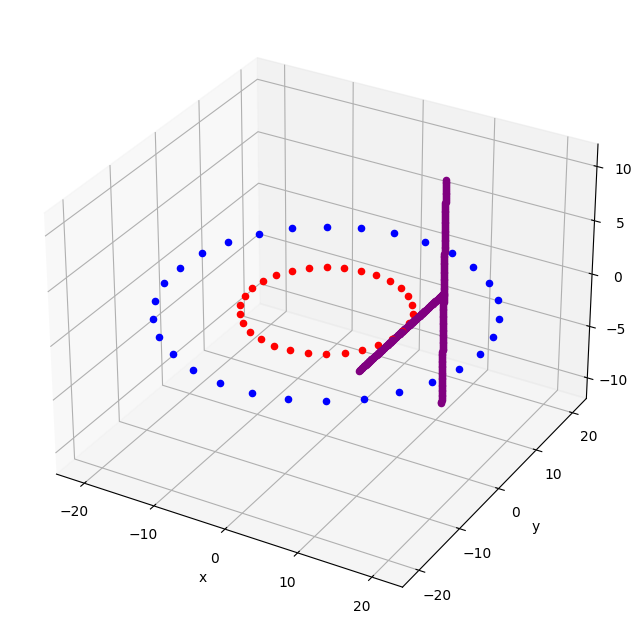

In [9]:
# Trying with unit circle
# theta = 0

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")


import math

def polar2cart(r, theta, phi, deg=True):
    if deg:
        theta = math.radians(theta)
        phi = math.radians(phi)
    return [
         r * math.sin(theta) * math.cos(phi),
         r * math.sin(theta) * math.sin(phi),
         r * math.cos(theta)
    ]

# print(polar2cart(5, 90, 0))

radius = 10.5
diam = 2 * radius
incr = diam / 127
N = 30
count = 0
for angle in np.linspace(0,360,N+1)[:-1]:
        # count += 1
        angle = max(0.1, angle)
        # theta = max(0.1, theta)
        # print(angle)
        # cart = polar_to_cartesian(radius, 0, angle, deg=True)
        # print(cart)
        cart = np.array(polar2cart(radius, 90, angle, deg=True))
        # print(cart)
        x = cart[0]
        y = cart[1]
        z = cart[2]
        # print(cart)
        perp = np.array([cart[1], -cart[0], cart[2]])
        # print(perp)
        start_horiz = cart - perp
        start_horiz[2] = cart[2]
        # print(start_horiz)
        # for i in range(-radius, radius + incr, incr):
        
        direction = (np.array([0, 0, cart[2]]) - cart) * 2
        print(direction)
        ax.scatter(direction[0], direction[1], direction[2], color="blue")
        ax.scatter(x,y,z, color="red") # plot the point (2,3,4) on the figure
        # ax.scatter(start_horiz[0],start_horiz[1],start_horiz[2], color="blue")
        
        if count < 2:
            incr_vector = 2 * (cart - start_horiz) / 127
            for i in range(128):
                curr = start_horiz + i * incr_vector
                # print(curr[2])
                ax.scatter(curr[0], curr[1], curr[2], color="purple")
                # ax.scatter(direction[0], direction[1], direction[2], color="blue")
                count += 1
                for j in range(128):
                    curr[2] = (-radius + j * (diam / 127))
                    if count < 2:
                        ax.scatter(curr[0], curr[1], curr[2], color="purple")
                    # accurate curr value here
        if count < 2:
            ax.scatter(x,y,z, color="orange") # plot the point (2,3,4) on the figure
            ax.scatter(start_horiz[0],start_horiz[1],start_horiz[2], color="green")

In [13]:
# Trying with unit circle
# theta = 0

# ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")


import math

def polar2cart(r, theta, phi, deg=True):
    if deg:
        theta = math.radians(theta)
        phi = math.radians(phi)
    return [
         r * math.sin(theta) * math.cos(phi),
         r * math.sin(theta) * math.sin(phi),
         r * math.cos(theta)
    ]

# print(polar2cart(5, 90, 0))

height = 128
width = 128
focal = 718
radius = 0.5 * (np.sqrt(2) / 2)
diam = 2 * radius
incr = diam / 127
N = 30
count = 0
def get_rays(angle):
    ray_origin = np.empty((128, 128, 3))
    ray_direction = np.empty((128, 128, 3))
    angle = max(0.1, angle)
    cart = np.array(polar2cart(radius, 90, angle, deg=True))
    x = cart[0]
    y = cart[1]
    z = cart[2]
    # print(cart)
    perp = np.array([cart[1], -cart[0], cart[2]])
    # print(perp)
    start_horiz = cart - perp
    start_horiz[2] = cart[2]
    # print(start_horiz)
    # ax.scatter(x,y,z, color="red") # plot the point (2,3,4) on the figure
    # ax.scatter(start_horiz[0],start_horiz[1],start_horiz[2], color="blue")
    direction = (np.array([0, 0, cart[2]]) - cart) * 2

    incr_vector = 2 * (cart - start_horiz) / 127
    for i in range(128):
        curr = start_horiz + i * incr_vector
        # print(curr[2])
        # ax.scatter(curr[0], curr[1], curr[2], color="purple")
        for j in range(128):
            curr[2] = (-radius + j * (diam / 127))
            ray_origin[j][i] = curr + [0.5, 0.5, 0.5]
            ray_direction[j][i] = direction
            # if count < 2:
            #     ax.scatter(curr[0], curr[1], curr[2], color="purple")
            # accurate curr value here
    
    # if count < 2:
    #     ax.scatter(x,y,z, color="orange") # plot the point (2,3,4) on the figure
    #     ax.scatter(start_horiz[0],start_horiz[1],start_horiz[2], color="green")
    # print(direction)
    # ax.scatter(direction[0], direction[1], direction[2], color="green")
    ray_origin = torch.from_numpy(ray_origin)
    ray_direction = torch.from_numpy(ray_direction)
    ray_origin = ray_origin.to(device)
    ray_direction = ray_direction.to(device)
    ray_origin = ray_origin.to(torch.float32)
    ray_direction = ray_direction.to(torch.float32)
    return ray_origin, ray_direction

ray_o, ray_d = get_rays(360)
print(type(ray_o))
print(type(ray_d))
print("ray_o")
print(ray_o[128 // 2, 128 // 2, :])
print("ray_d")
print(ray_d[128 // 2, 128 // 2, :])

<class 'torch.Tensor'>
<class 'torch.Tensor'>
ray_o
tensor([0.8536, 0.4972, 0.5028], device='cuda:0')
ray_d
tensor([-7.0711e-01,  1.7319e-16,  0.0000e+00], device='cuda:0')


0.0
0.1 tensor([0.8536, 0.4978, 0.5028], device='cuda:0') tensor([-0.7071, -0.0012,  0.0000], device='cuda:0')
5.0
5.0 tensor([0.8525, 0.5280, 0.5028], device='cuda:0') tensor([-0.7044, -0.0616,  0.0000], device='cuda:0')
10.0
10.0 tensor([0.8487, 0.5587, 0.5028], device='cuda:0') tensor([-0.6964, -0.1228,  0.0000], device='cuda:0')
15.0
15.0 tensor([0.8422, 0.5888, 0.5028], device='cuda:0') tensor([-0.6830, -0.1830,  0.0000], device='cuda:0')
20.0
20.0 tensor([0.8332, 0.6183, 0.5028], device='cuda:0') tensor([-0.6645, -0.2418,  0.0000], device='cuda:0')
25.0
25.0 tensor([0.8216, 0.6469, 0.5028], device='cuda:0') tensor([-0.6409, -0.2988,  0.0000], device='cuda:0')
30.0
30.0 tensor([0.8076, 0.6744, 0.5028], device='cuda:0') tensor([-0.6124, -0.3536,  0.0000], device='cuda:0')
35.0
35.0 tensor([0.7912, 0.7005, 0.5028], device='cuda:0') tensor([-0.5792, -0.4056,  0.0000], device='cuda:0')
40.0
40.0 tensor([0.7726, 0.7251, 0.5028], device='cuda:0') tensor([-0.5417, -0.4545,  0.0000], devi

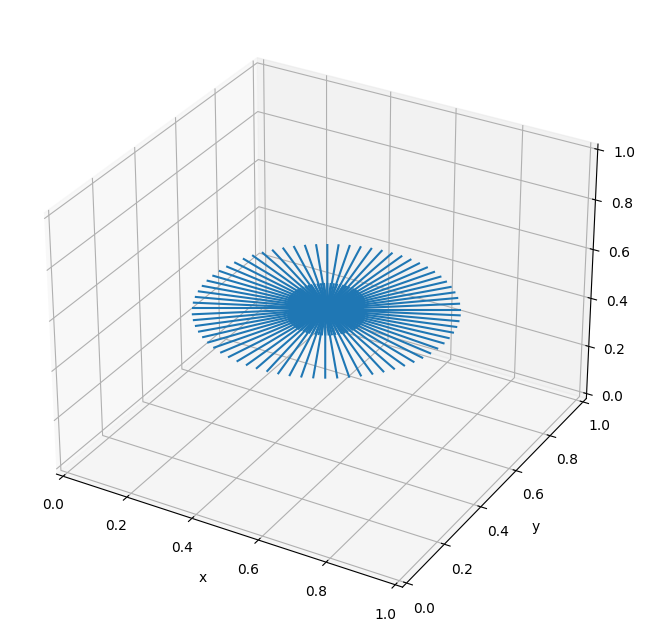

In [14]:
dirs = []
origins = []

for angle in np.linspace(0,360,73)[:-1]:    # print(pose)
    print(angle)
    angle = max(0.1, angle)
    # get_rays(central pixel)
    ray_origin, ray_direction = get_rays(angle)
    # print(ray_origin[height // 2, width // 2, :], ray_direction[height // 2, width // 2, :])
    print(angle, ray_origin[height // 2, width // 2, :], ray_direction[height // 2, width // 2, :])
    origins.append(ray_origin[height // 2, width // 2, :])
    dirs.append(ray_direction[height // 2, width // 2, :])

dirs = torch.stack(dirs)
origins = torch.stack(origins)
dirs = dirs.cpu()
origins = origins.cpu()

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

_ = ax.quiver(
  origins[..., 0].flatten(),
  origins[..., 1].flatten(),
  origins[..., 2].flatten(),
  dirs[..., 0].flatten(),
  dirs[..., 1].flatten(),
  dirs[..., 2].flatten(), length=0.5, normalize=False)
plt.show()

In [12]:
# from typing import Tuple
# def get_rays(
#   height: int,
#   width: int,
#   focal_length: float,
#   c2w: torch.Tensor
# ) -> Tuple[torch.Tensor, torch.Tensor]:
#   r"""
#   Find origin and direction of rays through every pixel and camera origin.
#   """

#   # Apply pinhole camera model to gather directions at each pixel
#   i, j = torch.meshgrid(
#       torch.arange(width, dtype=torch.float32).to(c2w),
#       torch.arange(height, dtype=torch.float32).to(c2w),
#       indexing='ij')
#   i, j = i.transpose(-1, -2), j.transpose(-1, -2)
#   directions = torch.stack([torch.zeros_like(i),
#                             torch.zeros_like(i),
#                             -torch.ones_like(i)
#                            ], dim=-1)

#   offsets = torch.stack([(i - width * .5)/scale_ct_image ,
#                          (j - height * .5)/scale_ct_image ,
#                             torch.zeros_like(i)
#                            ], dim=-1)

#   # Apply camera pose to directions
#   rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)

#   # Origin is same for all directions (the optical center)
#   rays_o = c2w[:3, -1].expand(rays_d.shape) + offsets
#   return rays_o, rays_d
from typing import Tuple
def get_rays(
    H: int,
    W: int,
    focal_length: float,
    c2w: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Similar structure to 'get_rays' in submodules/nerf_pytorch/run_nerf_helpers.py"""
    # # Rotate ray directions from camera frame to the world frame
    
    # print(c2w)
    
    size_h, size_w = focal_length, focal_length
    rays_d = -c2w[:3, 2].view(1, 1, 3).expand(W, H, -1)  # direction to center in world coordinates
    # print(rays_d.device)

    i, j = torch.meshgrid(torch.linspace(0, W - 1, W),
                          torch.linspace(0, H - 1, H))  # pytorch's meshgrid has indexing='ij'
    i = i.t()
    j = j.t()

    # Translation from center for origins
    rays_o = torch.stack([(i - W * .5), -(j - H * .5), torch.zeros_like(i)], -1)
    # print(rays_o.device)
    rays_o = rays_o.to(device)
    # print(rays_o.device)
    # Normalize to [-size_h/2, -size_w/2]
    scale = torch.tensor([size_w / W, size_h / H, 1]).view(1, 1, 3).to(device)
    # rays_o = rays_o * torch.tensor([size_w / W, size_h / H, 1]).view(1, 1, 3)
    rays_o = rays_o * scale

    # Rotate origins to the world frame
    rays_o = torch.sum(rays_o[..., None, :] * c2w[:3, :3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]

    # Translate origins to the world frame
    rays_o = rays_o + c2w[:3, -1].view(1, 1, 3)

    return rays_o, rays_d

In [10]:
def get_rays_ortho(H, W, c2w, size_h, size_w):
    """Similar structure to 'get_rays' in submodules/nerf_pytorch/run_nerf_helpers.py"""
    # # Rotate ray directions from camera frame to the world frame
    rays_d = -c2w[:3, 2].view(1, 1, 3).expand(W, H, -1)  # direction to center in world coordinates

    i, j = torch.meshgrid(torch.linspace(0, W - 1, W),
                          torch.linspace(0, H - 1, H))  # pytorch's meshgrid has indexing='ij'
    i = i.t()
    j = j.t()

    # Translation from center for origins
    rays_o = torch.stack([(i - W * .5), -(j - H * .5), torch.zeros_like(i)], -1)

    # Normalize to [-size_h/2, -size_w/2]
    rays_o = rays_o * torch.tensor([size_w / W, size_h / H, 1]).view(1, 1, 3)

    # Rotate origins to the world frame
    rays_o = torch.sum(rays_o[..., None, :] * c2w[:3, :3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]

    # Translate origins to the world frame
    rays_o = rays_o + c2w[:3, -1].view(1, 1, 3)

    return rays_o, rays_d

In [11]:
# get_rays_ortho(central pixel) to debug

# plot output like poses
# sample middle of each frame look for 72 poses

In [13]:
print(np.linspace(0,360,72+1)[:-1])


[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355.]


In [92]:
torch.__version__

'1.13.0+cu116'

In [15]:
print(images.shape[1:3])
print(hwfr[2])

torch.Size([128, 128])
731.523347376726


Images shape: torch.Size([72, 128, 128, 3])
Poses shape: (72,)
Focal length: 731.523347376726
Pose
355.0


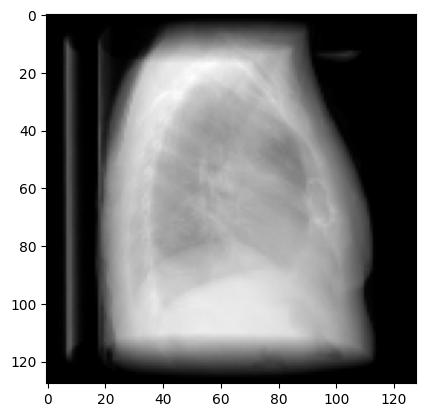

In [16]:
images = images
poses = np.linspace(0, 360, 72+1)[:-1]
# poses = render_poses
focal = focal_test # hwfr[2][0]

print(f'Images shape: {images.shape}')
print(f'Poses shape: {poses.shape}')
print(f'Focal length: {focal}')

height, width = hwfr[0], hwfr[1]
near, far = config['data']['near'], config['data']['far']

n_training = 70
testimg_idx = 71
testimg, testpose = images[testimg_idx], poses[testimg_idx]

plt.imshow(testimg)
print('Pose')
print(testpose)

In [17]:
images = images.numpy()
poses = poses
focal = np.array(focal)

In [18]:
testpose = np.array(testpose)

In [19]:
print(type(focal))

<class 'numpy.ndarray'>


In [20]:
data = {}
data['images'] = images
data['poses'] = poses
data['focal'] = focal

In [21]:
print(type(data['focal']))

<class 'numpy.ndarray'>


In [22]:
print(type(data['poses'][testimg_idx]))

<class 'numpy.float64'>


In [23]:
# Gather as torch tensors

# inputs = inputs.to(torch.float32)
images = torch.from_numpy(data['images'][:n_training]).to(torch.float32).to(device)
poses = torch.from_numpy(data['poses']).to(torch.float32).to(device)
focal = torch.from_numpy(data['focal']).to(torch.float32).to(device)
testimg = torch.from_numpy(data['images'][testimg_idx]).to(torch.float32).to(device)
testpose = torch.from_numpy(np.array(data['poses'][testimg_idx])).to(torch.float32).to(device)

# Grab rays from sample image
height, width = images.shape[1:3]
with torch.no_grad():
  # ray_origin, ray_direction = get_rays(height, width, focal, testpose)
    ray_origin, ray_direction = get_rays(testpose)
print('Ray Origin')
print(ray_origin.shape)
print(ray_origin[height // 2, width // 2, :])
print('')

print('Ray Direction')
print(ray_direction.shape)
print(ray_direction[height // 2, width // 2, :])
print('')

Ray Origin
torch.Size([128, 128, 3])
tensor([0.8520, 0.4664, 0.5028], device='cuda:0')

Ray Direction
torch.Size([128, 128, 3])
tensor([-0.7044,  0.0616,  0.0000], device='cuda:0')



In [24]:
print(device)

cuda


In [25]:
len(poses[:72])

72

In [26]:
for pose in poses[:1]:
    ray_origin, ray_direction = get_rays(pose)
print(ray_origin[height // 2, width // 2, :], ray_direction[height // 2, width // 2, :])

tensor([0.8536, 0.4978, 0.5028], device='cuda:0') tensor([-0.7071, -0.0012,  0.0000], device='cuda:0')


In [118]:
def get_rays_test(
  height: int,
  width: int,
  focal_length: float,
  c2w: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
  r"""
  Find origin and direction of rays through every pixel and camera origin.
  """

  # Apply pinhole camera model to gather directions at each pixel
  i, j = torch.meshgrid(
      torch.arange(width, dtype=torch.float32).to(c2w),
      torch.arange(height, dtype=torch.float32).to(c2w),
      indexing='ij')
  i, j = i.transpose(-1, -2), j.transpose(-1, -2)
  directions = torch.stack([torch.zeros_like(i),
                            torch.zeros_like(i),
                            -torch.ones_like(i)
                           ], dim=-1)

  offsets = torch.stack([(i - width * .5)/ focal_length ,
                         (j - height * .5)/ focal_length ,
                            torch.zeros_like(i)
                           ], dim=-1)

  # Apply camera pose to directions
  rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)

  # Origin is same for all directions (the optical center)
  rays_o = c2w[:3, -1].expand(rays_d.shape) + offsets
  return rays_o, rays_d

In [24]:
o, d = get_rays_test(height, width, focal, poses[0])
print(o.shape)
print(o)
# print(o[height // 2, width // 2, :])
# print(d[height // 2, width // 2, :])

torch.Size([128, 128, 3])
tensor([[[10.1636, -0.0696,  2.2726],
         [10.1650, -0.0696,  2.2726],
         [10.1663, -0.0696,  2.2726],
         ...,
         [10.3345, -0.0696,  2.2726],
         [10.3358, -0.0696,  2.2726],
         [10.3372, -0.0696,  2.2726]],

        [[10.1636, -0.0682,  2.2726],
         [10.1650, -0.0682,  2.2726],
         [10.1663, -0.0682,  2.2726],
         ...,
         [10.3345, -0.0682,  2.2726],
         [10.3358, -0.0682,  2.2726],
         [10.3372, -0.0682,  2.2726]],

        [[10.1636, -0.0669,  2.2726],
         [10.1650, -0.0669,  2.2726],
         [10.1663, -0.0669,  2.2726],
         ...,
         [10.3345, -0.0669,  2.2726],
         [10.3358, -0.0669,  2.2726],
         [10.3372, -0.0669,  2.2726]],

        ...,

        [[10.1636,  0.1013,  2.2726],
         [10.1650,  0.1013,  2.2726],
         [10.1663,  0.1013,  2.2726],
         ...,
         [10.3345,  0.1013,  2.2726],
         [10.3358,  0.1013,  2.2726],
         [10.3372,  0.10

In [25]:
ray_origin.shape

torch.Size([128, 128, 3])

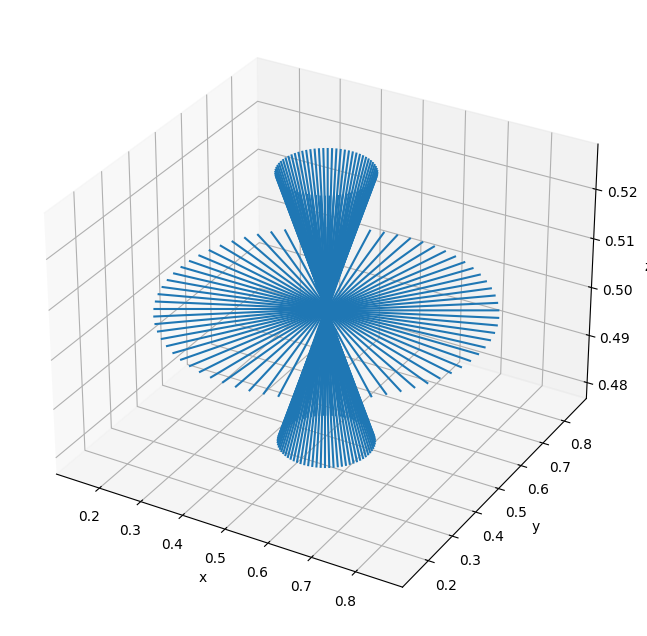

In [27]:
# print(poses[0][:3, :3])
# replace dirs with dirs from for loop calling get_rays_ortho(central pixel)
# print(poses[0])
dirs = []
origins = []

for pose in poses[:72]:
    # print(pose)
    # get_rays(central pixel)
    ray_origin, ray_direction = get_rays(pose)
    origins.append(ray_origin[height // 2, width // 2, :])
    # test = torch.clone(ray_origin[height // 2, width // 2, :])
    # test[2] = 0
    dirs.append(ray_direction[height // 2, width // 2, :])

# #     # dirs.append(test)
# ray_origin, ray_direction = get_rays(height, width, focal, poses[0])
# print(ray_origin[height // 2, width // 2, :])
# ray_origin, ray_direction = get_rays(height, width, focal, poses[0])
# for i in range(0, 128):
#     origins.append(ray_origin[i, 0, :])
#     dirs.append(ray_direction[i, 0, :])



dirs = torch.stack(dirs)
origins = torch.stack(origins)
dirs = dirs.cpu()
origins = origins.cpu()

# print(dirs)
# print(origins)
# dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
# origins = poses[:, :3, -1]

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

_ = ax.quiver(
  origins[..., 0].flatten(),
  origins[..., 1].flatten(),
  origins[..., 2].flatten(),
  dirs[..., 0].flatten(),
  dirs[..., 1].flatten(),
  dirs[..., 2].flatten(), length=0.5, normalize=False)
plt.show()

In [28]:
print(dirs[0])

tensor([-0.7071, -0.0012,  0.0000])


In [29]:
print(origins[0])

tensor([0.8536, 0.4978, 0.5028])


tensor(0., device='cuda:0')
tensor([0.8542, 0.1471, 0.5028], device='cuda:0')
tensor([0.8536, 0.4978, 0.5028], device='cuda:0')
tensor(5., device='cuda:0')
tensor([0.8830, 0.1786, 0.5028], device='cuda:0')
tensor([0.8525, 0.5280, 0.5028], device='cuda:0')
tensor(10., device='cuda:0')
tensor([0.9096, 0.2132, 0.5028], device='cuda:0')
tensor([0.8487, 0.5587, 0.5028], device='cuda:0')
tensor(15., device='cuda:0')
tensor([0.9330, 0.2500, 0.5028], device='cuda:0')
tensor([0.8422, 0.5888, 0.5028], device='cuda:0')
tensor(20., device='cuda:0')
tensor([0.9532, 0.2887, 0.5028], device='cuda:0')
tensor([0.8332, 0.6183, 0.5028], device='cuda:0')
tensor(25., device='cuda:0')
tensor([0.9698, 0.3290, 0.5028], device='cuda:0')
tensor([0.8216, 0.6469, 0.5028], device='cuda:0')
tensor(30., device='cuda:0')
tensor([0.9830, 0.3706, 0.5028], device='cuda:0')
tensor([0.8076, 0.6744, 0.5028], device='cuda:0')
tensor(35., device='cuda:0')
tensor([0.9924, 0.4132, 0.5028], device='cuda:0')
tensor([0.7912, 0.70

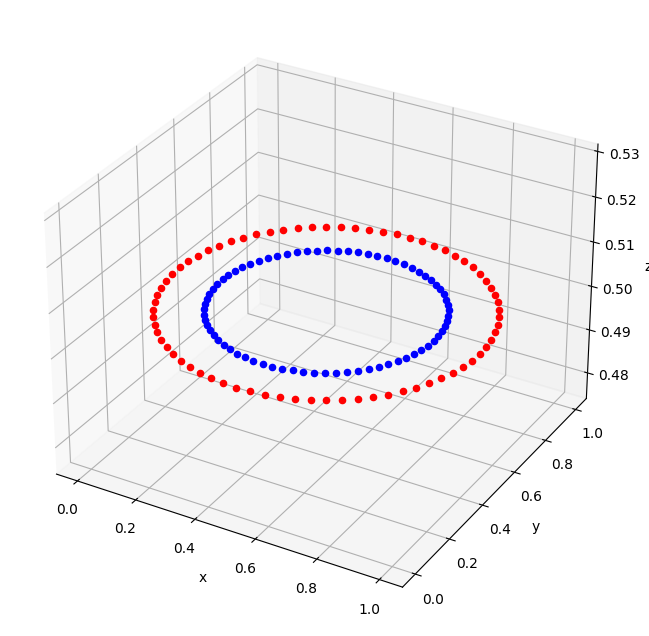

In [30]:
ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
for pose in poses[:72]:
    
    # print(pose[:3, :3])
    print(pose)
    ray_origin, ray_direction = get_rays(pose)
    
    # print("---------------")
    # print(ray_origin)
    # print("---------------")

    # point = ray_direction[height // 2, width // 2, :]
    # print(ray_origin[height // 2, width // 2, :])
    # print(ray_origin.shape)
    test = torch.clone(ray_origin[height // 2, width // 2, :])
    test[0] = -test[0]
    test[1] = -test[1]
    # print(ray_direction[height // 2, width // 2, :])
    point = ray_origin[64, 127, :]
    # print("point 1")
    # print(point)
    # print(type(point))
    # print(point)
    # x = test[0].cpu()
    # y = test[1].cpu()
    # z = test[2].cpu()
    x = point[0].cpu()
    y = point[1].cpu()
    z = point[2].cpu()
    ax.scatter(x,y,z, color="red") # plot the point (2,3,4) on the figure
    print(point)
    

    point2 = ray_origin[64, 64, :]
    # print("point 2")
    # print(point2)
    x_ = point2[0].cpu()
    y_ = point2[1].cpu()
    z_ = point2[2].cpu()
    ax.scatter(x_,y_,z_, color="blue") # plot the point (2,3,4) on the figure
    print(point2)
    # point3 = ray_origin[0, 127, :]
    # # print("point 2")
    # # print(point2)
    # x_1 = point3[0].cpu()
    # y_1 = point3[1].cpu()
    # z_1 = point3[2].cpu()
    # ax.scatter(x_1,y_1,z_1, color="green") # plot the point (2,3,4) on the figure
    # point4 = ray_origin[127, 0, :]
    # # print("point 2")
    # # print(point2)
    # x_2 = point4[0].cpu()
    # y_2 = point4[1].cpu()
    # z_2 = point4[2].cpu()
    # ax.scatter(x_2,y_2,z_2, color="orange") # plot the point (2,3,4) on the figure
# print(point, point2, point3, point4)
plt.show()

In [31]:
def sample_stratified(
  rays_o: torch.Tensor,
  rays_d: torch.Tensor,
  near: float,
  far: float,
  n_samples: int,
  perturb: Optional[bool] = True,
  inverse_depth: bool = False
) -> Tuple[torch.Tensor, torch.Tensor]:
  r"""
  Sample along ray from regularly-spaced bins.
  """

  # Grab samples for space integration along ray
  t_vals = torch.linspace(0., 1., n_samples, device=rays_o.device)
  if not inverse_depth:
    # Sample linearly between `near` and `far`
    z_vals = near * (1.-t_vals) + far * (t_vals)
  else:
    # Sample linearly in inverse depth (disparity)
    z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

  # Draw uniform samples from bins along ray
  if perturb:
    mids = .5 * (z_vals[1:] + z_vals[:-1])
    upper = torch.concat([mids, z_vals[-1:]], dim=-1)
    lower = torch.concat([z_vals[:1], mids], dim=-1)
    t_rand = torch.rand([n_samples], device=z_vals.device)
    z_vals = lower + (upper - lower) * t_rand
  z_vals = z_vals.expand(list(rays_o.shape[:-1]) + [n_samples])

  # Apply scale from `rays_d` and offset from `rays_o` to samples
  # pts: (width, height, n_samples, 3)
  pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
  return pts, z_vals

In [32]:
# Draw stratified samples from example
rays_o = ray_origin.view([-1, 3])
rays_d = ray_direction.view([-1, 3])
n_samples = 8
perturb = True
inverse_depth = False
with torch.no_grad():
  pts, z_vals = sample_stratified(rays_o, rays_d, near, far, n_samples,
                                  perturb=perturb, inverse_depth=inverse_depth)

print('Input Points')
print(pts.shape)
print('')
print('Distances Along Ray')
print(z_vals.shape)

Input Points
torch.Size([16384, 8, 3])

Distances Along Ray
torch.Size([16384, 8])


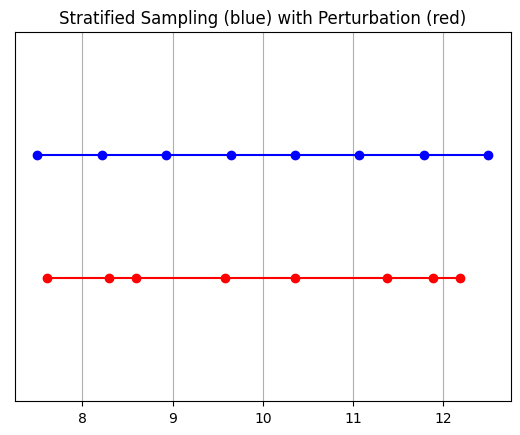

In [33]:
y_vals = torch.zeros_like(z_vals)

_, z_vals_unperturbed = sample_stratified(rays_o, rays_d, near, far, n_samples,
                                  perturb=False, inverse_depth=inverse_depth)
plt.plot(z_vals_unperturbed[0].cpu().numpy(), 1 + y_vals[0].cpu().numpy(), 'b-o')
plt.plot(z_vals[0].cpu().numpy(), y_vals[0].cpu().numpy(), 'r-o')
plt.ylim([-1, 2])
plt.title('Stratified Sampling (blue) with Perturbation (red)')
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.grid(True)

In [34]:
class PositionalEncoder(nn.Module):
  r"""
  Sine-cosine positional encoder for input points.
  """
  def __init__(
    self,
    d_input: int,
    n_freqs: int,
    log_space: bool = False
  ):
    super().__init__()
    self.d_input = d_input
    self.n_freqs = n_freqs
    self.log_space = log_space
    self.d_output = d_input * (1 + 2 * self.n_freqs)
    self.embed_fns = [lambda x: x]

    # Define frequencies in either linear or log scale
    if self.log_space:
      freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs)
    else:
      freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

    # Alternate sin and cos
    for freq in freq_bands:
      self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
      self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))
  
  def forward(
    self,
    x
  ) -> torch.Tensor:
    r"""
    Apply positional encoding to input.
    """
    return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)


In [35]:
# Create encoders for points and view directions
encoder = PositionalEncoder(3, 10)
viewdirs_encoder = PositionalEncoder(3, 4)

# Grab flattened points and view directions
pts_flattened = pts.reshape(-1, 3)
viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
flattened_viewdirs = viewdirs[:, None, ...].expand(pts.shape).reshape((-1, 3))

# Encode inputs
encoded_points = encoder(pts_flattened)
encoded_viewdirs = viewdirs_encoder(flattened_viewdirs)

print('Encoded Points')
print(encoded_points.shape)
print(torch.min(encoded_points), torch.max(encoded_points), torch.mean(encoded_points))
print('')

print(encoded_viewdirs.shape)
print('Encoded Viewdirs')
print(torch.min(encoded_viewdirs), torch.max(encoded_viewdirs), torch.mean(encoded_viewdirs))
print('')

Encoded Points
torch.Size([131072, 63])
tensor(-7.7592, device='cuda:0') tensor(1.5721, device='cuda:0') tensor(-0.0232, device='cuda:0')

torch.Size([131072, 27])
Encoded Viewdirs
tensor(-0.9962, device='cuda:0') tensor(1., device='cuda:0') tensor(0.2730, device='cuda:0')



In [36]:
class NeRF(nn.Module):
  r"""
  Neural radiance fields module.
  """
  def __init__(
    self,
    d_input: int = 3,
    n_layers: int = 8,
    d_filter: int = 256,
    skip: Tuple[int] = (4,),
    d_viewdirs: Optional[int] = None
  ):
    super().__init__()
    self.d_input = d_input
    self.skip = skip
    self.act = nn.functional.relu
    self.d_viewdirs = d_viewdirs

    # Create model layers
    self.layers = nn.ModuleList(
      [nn.Linear(self.d_input, d_filter)] +
      [nn.Linear(d_filter + self.d_input, d_filter) if i in skip \
       else nn.Linear(d_filter, d_filter) for i in range(n_layers - 1)]
    )

    # Bottleneck layers
    # if self.d_viewdirs is not None:
    #   # If using viewdirs, split alpha and RGB
    #   self.alpha_out = nn.Linear(d_filter, 1)
    #   self.rgb_filters = nn.Linear(d_filter, d_filter)
    #   self.branch = nn.Linear(d_filter + self.d_viewdirs, d_filter // 2)
    #   self.output = nn.Linear(d_filter // 2, 3)
    # else:
    
    
    # If no viewdirs, use simpler output
    self.output = nn.Linear(d_filter, 4)
  
  def forward(
    self,
    x: torch.Tensor,
    viewdirs: Optional[torch.Tensor] = None
  ) -> torch.Tensor:
    r"""
    Forward pass with optional view direction.
    """

    # Cannot use viewdirs if instantiated with d_viewdirs = None
    if self.d_viewdirs is None and viewdirs is not None:
      raise ValueError('Cannot input x_direction if d_viewdirs was not given.')

    # Apply forward pass up to bottleneck
    x_input = x
    for i, layer in enumerate(self.layers):
      x = self.act(layer(x))
      if i in self.skip:
        x = torch.cat([x, x_input], dim=-1)

    # Apply bottleneck
#     if self.d_viewdirs is not None:
#       # Split alpha from network output
#       alpha = self.alpha_out(x)

#       # Pass through bottleneck to get RGB
#       x = self.rgb_filters(x)
#       x = torch.concat([x, viewdirs], dim=-1)
#       x = self.act(self.branch(x))
#       x = self.output(x)

#       # Concatenate alphas to output
#       x = torch.concat([x, alpha], dim=-1)
#     else:
      
    
    # Eliminate View Direction
    # Simple output
    x = self.output(x)
    return x

In [37]:
def cumprod_exclusive(
  tensor: torch.Tensor
) -> torch.Tensor:
  r"""
  (Courtesy of https://github.com/krrish94/nerf-pytorch)

  Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
  tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
    is to be computed.
  Returns:
  cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
    tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """

  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, -1)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, -1)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.
  
  return cumprod



def raw2outputs(
  raw: torch.Tensor,
  z_vals: torch.Tensor,
  rays_d: torch.Tensor,
  raw_noise_std: float = 0.0,
  white_bkgd: bool = False
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
  r"""
  Convert the raw NeRF output into RGB and other maps.
  """

  # Difference between consecutive elements of `z_vals`. [n_rays, n_samples]
  dists = z_vals[..., 1:] - z_vals[..., :-1]
  dists = torch.cat([dists, 1e10 * torch.ones_like(dists[..., :1])], dim=-1)

  # Multiply each distance by the norm of its corresponding direction ray
  # to convert to real world distance (accounts for non-unit directions).
  dists = dists * torch.norm(rays_d[..., None, :], dim=-1)

  # Add noise to model's predictions for density. Can be used to 
  # regularize network during training (prevents floater artifacts).
  noise = 0.
  if raw_noise_std > 0.:
    noise = torch.randn(raw[..., 3].shape) * raw_noise_std

  # Predict density of each sample along each ray. Higher values imply
  # higher likelihood of being absorbed at this point. [n_rays, n_samples]
  sigmoid = nn.Sigmoid()
  alpha = sigmoid((nn.functional.relu(raw[..., 3] + noise) * dists))

  # Compute weight for RGB of each sample along each ray. [n_rays, n_samples]
  # The higher the alpha, the lower subsequent weights are driven.
  weights = alpha

  # Compute weighted RGB map.
  rgb = torch.sigmoid(raw[..., :3])  # [n_rays, n_samples, 3]
  rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)  # [n_rays, 3]

  # Estimated depth map is predicted distance.
  depth_map = torch.sum(weights * z_vals, dim=-1)

  # Disparity map is inverse depth.
  disp_map = 1. / torch.max(1e-10 * torch.ones_like(depth_map),
                            depth_map / torch.sum(weights, -1))

  # Sum of weights along each ray. In [0, 1] up to numerical error.
  acc_map = torch.sum(weights, dim=-1)

  # To composite onto a white background, use the accumulated alpha map.
  if white_bkgd:
    rgb_map = rgb_map + (1. - acc_map[..., None])

  return rgb_map, depth_map, acc_map, weights

In [38]:
def sample_pdf(
  bins: torch.Tensor,
  weights: torch.Tensor,
  n_samples: int,
  perturb: bool = False
) -> torch.Tensor:
  r"""
  Apply inverse transform sampling to a weighted set of points.
  """

  # Normalize weights to get PDF.
  pdf = (weights + 1e-5) / torch.sum(weights + 1e-5, -1, keepdims=True) # [n_rays, weights.shape[-1]]

  # Convert PDF to CDF.
  cdf = torch.cumsum(pdf, dim=-1) # [n_rays, weights.shape[-1]]
  cdf = torch.concat([torch.zeros_like(cdf[..., :1]), cdf], dim=-1) # [n_rays, weights.shape[-1] + 1]

  # Take sample positions to grab from CDF. Linear when perturb == 0.
  if not perturb:
    u = torch.linspace(0., 1., n_samples, device=cdf.device)
    u = u.expand(list(cdf.shape[:-1]) + [n_samples]) # [n_rays, n_samples]
  else:
    u = torch.rand(list(cdf.shape[:-1]) + [n_samples], device=cdf.device) # [n_rays, n_samples]

  # Find indices along CDF where values in u would be placed.
  u = u.contiguous() # Returns contiguous tensor with same values.
  inds = torch.searchsorted(cdf, u, right=True) # [n_rays, n_samples]

  # Clamp indices that are out of bounds.
  below = torch.clamp(inds - 1, min=0)
  above = torch.clamp(inds, max=cdf.shape[-1] - 1)
  inds_g = torch.stack([below, above], dim=-1) # [n_rays, n_samples, 2]

  # Sample from cdf and the corresponding bin centers.
  matched_shape = list(inds_g.shape[:-1]) + [cdf.shape[-1]]
  cdf_g = torch.gather(cdf.unsqueeze(-2).expand(matched_shape), dim=-1,
                       index=inds_g)
  bins_g = torch.gather(bins.unsqueeze(-2).expand(matched_shape), dim=-1,
                        index=inds_g)

  # Convert samples to ray length.
  denom = (cdf_g[..., 1] - cdf_g[..., 0])
  denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
  t = (u - cdf_g[..., 0]) / denom
  samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

  return samples # [n_rays, n_samples]

In [39]:
def sample_hierarchical(
  rays_o: torch.Tensor,
  rays_d: torch.Tensor,
  z_vals: torch.Tensor,
  weights: torch.Tensor,
  n_samples: int,
  perturb: bool = False
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
  r"""
  Apply hierarchical sampling to the rays.
  """

  # Draw samples from PDF using z_vals as bins and weights as probabilities.
  z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
  new_z_samples = sample_pdf(z_vals_mid, weights[..., 1:-1], n_samples,
                          perturb=perturb)
  new_z_samples = new_z_samples.detach()

  # Resample points from ray based on PDF.
  z_vals_combined, _ = torch.sort(torch.cat([z_vals, new_z_samples], dim=-1), dim=-1)
  pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals_combined[..., :, None]  # [N_rays, N_samples + n_samples, 3]
  return pts, z_vals_combined, new_z_samples

In [40]:
def get_chunks(
  inputs: torch.Tensor,
  chunksize: int = 2**15
) -> List[torch.Tensor]:
  r"""
  Divide an input into chunks.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

def prepare_chunks(
  points: torch.Tensor,
  encoding_function: Callable[[torch.Tensor], torch.Tensor],
  chunksize: int = 2**15
) -> List[torch.Tensor]:
  r"""
  Encode and chunkify points to prepare for NeRF model.
  """
  points = points.reshape((-1, 3))
  points = encoding_function(points)
  points = get_chunks(points, chunksize=chunksize)
  return points

def prepare_viewdirs_chunks(
  points: torch.Tensor,
  rays_d: torch.Tensor,
  encoding_function: Callable[[torch.Tensor], torch.Tensor],
  chunksize: int = 2**15
) -> List[torch.Tensor]:
  r"""
  Encode and chunkify viewdirs to prepare for NeRF model.
  """
  # Prepare the viewdirs
  viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
  viewdirs = viewdirs[:, None, ...].expand(points.shape).reshape((-1, 3))
  viewdirs = encoding_function(viewdirs)
  viewdirs = get_chunks(viewdirs, chunksize=chunksize)
  return viewdirs

In [41]:
def nerf_forward(
  rays_o: torch.Tensor,
  rays_d: torch.Tensor,
  near: float,
  far: float,
  encoding_fn: Callable[[torch.Tensor], torch.Tensor],
  coarse_model: nn.Module,
  kwargs_sample_stratified: dict = None,
  n_samples_hierarchical: int = 0,
  kwargs_sample_hierarchical: dict = None,
  fine_model = None,
  viewdirs_encoding_fn: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
  chunksize: int = 2**15
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, dict]:
  r"""
  Compute forward pass through model(s).
  """

  # Set no kwargs if none are given.
  if kwargs_sample_stratified is None:
    kwargs_sample_stratified = {}
  if kwargs_sample_hierarchical is None:
    kwargs_sample_hierarchical = {}
  
  # Sample query points along each ray.
  query_points, z_vals = sample_stratified(
      rays_o, rays_d, near, far, **kwargs_sample_stratified)

  # Prepare batches.
  batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
  if viewdirs_encoding_fn is not None:
    batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d,
                                               viewdirs_encoding_fn,
                                               chunksize=chunksize)
  else:
    batches_viewdirs = [None] * len(batches)

  # Coarse model pass.
  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  predictions = []
  for batch, batch_viewdirs in zip(batches, batches_viewdirs):
    predictions.append(coarse_model(batch, viewdirs=batch_viewdirs))
  raw = torch.cat(predictions, dim=0)
  raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals, rays_d)
  # rgb_map, depth_map, acc_map, weights = render_volume_density(raw, rays_o, z_vals)
  outputs = {
      'z_vals_stratified': z_vals
  }

  # Fine model pass.
  if n_samples_hierarchical > 0:
    # Save previous outputs to return.
    rgb_map_0, depth_map_0, acc_map_0 = rgb_map, depth_map, acc_map

    # Apply hierarchical sampling for fine query points.
    query_points, z_vals_combined, z_hierarch = sample_hierarchical(
      rays_o, rays_d, z_vals, weights, n_samples_hierarchical,
      **kwargs_sample_hierarchical)

    # Prepare inputs as before.
    batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
    if viewdirs_encoding_fn is not None:
      batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d,
                                                 viewdirs_encoding_fn,
                                                 chunksize=chunksize)
    else:
      batches_viewdirs = [None] * len(batches)

    # Forward pass new samples through fine model.
    fine_model = fine_model if fine_model is not None else coarse_model
    predictions = []
    for batch, batch_viewdirs in zip(batches, batches_viewdirs):
      predictions.append(fine_model(batch, viewdirs=batch_viewdirs))
    raw = torch.cat(predictions, dim=0)
    raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])

    # Perform differentiable volume rendering to re-synthesize the RGB image.
    rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals_combined, rays_d)
    
    # Store outputs.
    outputs['z_vals_hierarchical'] = z_hierarch
    outputs['rgb_map_0'] = rgb_map_0
    outputs['depth_map_0'] = depth_map_0
    outputs['acc_map_0'] = acc_map_0

  # Store outputs.
  outputs['rgb_map'] = rgb_map
  outputs['depth_map'] = depth_map
  outputs['acc_map'] = acc_map
  outputs['weights'] = weights
  return outputs

In [42]:
# Encoders
d_input = 3           # Number of input dimensions
n_freqs = 10          # Number of encoding functions for samples
log_space = True      # If set, frequencies scale in log space
use_viewdirs = True   # If set, use view direction as input
n_freqs_views = 4     # Number of encoding functions for views

# Stratified sampling
n_samples = 64         # Number of spatial samples per ray
perturb = True         # If set, applies noise to sample positions
inverse_depth = False  # If set, samples points linearly in inverse depth

# Model
d_filter = 128          # Dimensions of linear layer filters
n_layers = 2            # Number of layers in network bottleneck
skip = []               # Layers at which to apply input residual
use_fine_model = True   # If set, creates a fine model
d_filter_fine = 128     # Dimensions of linear layer filters of fine network
n_layers_fine = 6       # Number of layers in fine network bottleneck

# Hierarchical sampling
n_samples_hierarchical = 64   # Number of samples per ray
perturb_hierarchical = False  # If set, applies noise to sample positions

# Optimizer
lr = 5e-4  # Learning rate

# Training
n_iters = 10000
batch_size = 2**14          # Number of rays per gradient step (power of 2)
one_image_per_step = True   # One image per gradient step (disables batching)
chunksize = 2**14           # Modify as needed to fit in GPU memory
center_crop = False          # Crop the center of image (one_image_per_)
center_crop_iters = 50      # Stop cropping center after this many epochs
display_rate = 25          # Display test output every X epochs

# Early Stopping
warmup_iters = 100          # Number of iterations during warmup phase
warmup_min_fitness = 10.0   # Min val PSNR to continue training at warmup_iters
n_restarts = 10             # Number of times to restart if training stalls

# We bundle the kwargs for various functions to pass all at once.
kwargs_sample_stratified = {
    'n_samples': n_samples,
    'perturb': perturb,
    'inverse_depth': inverse_depth
}
kwargs_sample_hierarchical = {
    'perturb': perturb
}

In [43]:
def plot_samples(
  z_vals: torch.Tensor,
  z_hierarch: Optional[torch.Tensor] = None,
  ax: Optional[np.ndarray] = None):
  r"""
  Plot stratified and (optional) hierarchical samples.
  """
  y_vals = 1 + np.zeros_like(z_vals)

  if ax is None:
    ax = plt.subplot()
  ax.plot(z_vals, y_vals, 'b-o')
  if z_hierarch is not None:
    y_hierarch = np.zeros_like(z_hierarch)
    ax.plot(z_hierarch, y_hierarch, 'r-o')
  ax.set_ylim([-1, 2])
  ax.set_title('Stratified  Samples (blue) and Hierarchical Samples (red)')
  ax.axes.yaxis.set_visible(False)
  ax.grid(True)
  return ax

def crop_center(
  img: torch.Tensor,
  frac: float = 0.5
) -> torch.Tensor:
  r"""
  Crop center square from image.
  """
  h_offset = round(img.shape[0] * (frac / 2))
  w_offset = round(img.shape[1] * (frac / 2))
  return img[h_offset:-h_offset, w_offset:-w_offset]

class EarlyStopping:
  r"""
  Early stopping helper based on fitness criterion.
  """
  def __init__(
    self,
    patience: int = 30,
    margin: float = 1e-4
  ):
    self.best_fitness = 0.0  # In our case PSNR
    self.best_iter = 0
    self.margin = margin
    self.patience = patience or float('inf')  # epochs to wait after fitness stops improving to stop

  def __call__(
    self,
    iter: int,
    fitness: float
  ):
    r"""
    Check if criterion for stopping is met.
    """
    if (fitness - self.best_fitness) > self.margin:
      self.best_iter = iter
      self.best_fitness = fitness
    delta = iter - self.best_iter
    stop = delta >= self.patience  # stop training if patience exceeded
    return stop

In [44]:
def init_models():
  r"""
  Initialize models, encoders, and optimizer for NeRF training.
  """
  # Encoders
  encoder = PositionalEncoder(d_input, n_freqs, log_space=log_space)
  encode = lambda x: encoder(x)

  # View direction encoders
  if use_viewdirs:
    encoder_viewdirs = PositionalEncoder(d_input, n_freqs_views,
                                        log_space=log_space)
    encode_viewdirs = lambda x: encoder_viewdirs(x)
    d_viewdirs = encoder_viewdirs.d_output
  else:
    encode_viewdirs = None
    d_viewdirs = None

  # Models
  model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip,
              d_viewdirs=d_viewdirs)
  model.to(device)
  model_params = list(model.parameters())
  if use_fine_model:
    fine_model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip,
                      d_viewdirs=d_viewdirs)
    fine_model.to(device)
    model_params = model_params + list(fine_model.parameters())
  else:
    fine_model = None

  # Optimizer
  optimizer = torch.optim.Adam(model_params, lr=lr)

  # Early Stopping
  warmup_stopper = EarlyStopping(patience=50)

  return model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper

In [45]:
def train():
  r"""
  Launch training session for NeRF.
  """
  # Shuffle rays across all images.
  if not one_image_per_step:
    height, width = images.shape[1:3]
    # all_rays = torch.stack([torch.stack(get_rays(height, width, focal, p), 0)
    #                     for p in poses[:n_training]], 0)
    all_rays = torch.stack([torch.stack(get_rays(p), 0)
                        for p in poses[:n_training]], 0)
    rays_rgb = torch.cat([all_rays, images[:, None]], 1)
    rays_rgb = torch.permute(rays_rgb, [0, 2, 3, 1, 4])
    rays_rgb = rays_rgb.reshape([-1, 3, 3])
    rays_rgb = rays_rgb.type(torch.float32)
    rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
    i_batch = 0

  train_psnrs = []
  val_psnrs = []
  iternums = []
  for i in trange(n_iters):
    model.train()

    if one_image_per_step:
      # Randomly pick an image as the target.
      target_img_idx = np.random.randint(images.shape[0])
      # print(target_img_idx)
      target_img = images[target_img_idx].to(device)
      # print(target_img.shape)
    
    
    
      # COMMENT OUT??
      # if center_crop and i < center_crop_iters:
      #   target_img = crop_center(target_img)
      # print(target_img.shape)
      height, width = target_img.shape[:2]
      target_pose = poses[target_img_idx].to(device)
      # rays_o, rays_d = get_rays(height, width, focal, target_pose)
      rays_o, rays_d = get_rays(target_pose)
      rays_o = rays_o.reshape([-1, 3])
      rays_d = rays_d.reshape([-1, 3])
    else:
      # Random over all images.
      batch = rays_rgb[i_batch:i_batch + batch_size]
      batch = torch.transpose(batch, 0, 1)
      rays_o, rays_d, target_img = batch
      height, width = target_img.shape[:2]
      i_batch += batch_size
      # Shuffle after one epoch
      if i_batch >= rays_rgb.shape[0]:
          rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
          i_batch = 0
    target_img = target_img.reshape([-1, 3])

    # Run one iteration of TinyNeRF and get the rendered RGB image.
    outputs = nerf_forward(rays_o, rays_d,
                           near, far, encode, model,
                           kwargs_sample_stratified=kwargs_sample_stratified,
                           n_samples_hierarchical=n_samples_hierarchical,
                           kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                           fine_model=fine_model,
                           viewdirs_encoding_fn=encode_viewdirs,
                           chunksize=chunksize)
    
    # Check for any numerical issues.
    for k, v in outputs.items():
      if torch.isnan(v).any():
        print(f"! [Numerical Alert] {k} contains NaN.")
      if torch.isinf(v).any():
        print(f"! [Numerical Alert] {k} contains Inf.")

    # Backprop!
    rgb_predicted = outputs['rgb_map']
    # print(rgb_predicted.shape, target_img.shape)
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Compute mean-squared error between predicted and target images.
    psnr = -10. * torch.log10(loss)
    train_psnrs.append(psnr.item())

    # Evaluate testimg at given display rate.
    if i % display_rate == 0:
      model.eval()
      height, width = testimg.shape[:2]
      # rays_o, rays_d = get_rays(height, width, focal, testpose)
      rays_o, rays_d = get_rays(testpose)

      rays_o = rays_o.reshape([-1, 3])
      rays_d = rays_d.reshape([-1, 3])
      outputs = nerf_forward(rays_o, rays_d,
                             near, far, encode, model,
                             kwargs_sample_stratified=kwargs_sample_stratified,
                             n_samples_hierarchical=n_samples_hierarchical,
                             kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                             fine_model=fine_model,
                             viewdirs_encoding_fn=encode_viewdirs,
                             chunksize=chunksize)

      rgb_predicted = outputs['rgb_map']
      loss = torch.nn.functional.mse_loss(rgb_predicted, testimg.reshape(-1, 3))
      print("Loss:", loss.item())
      val_psnr = -10. * torch.log10(loss)
      
      val_psnrs.append(val_psnr.item())
      iternums.append(i)

      # Plot example outputs
      fig, ax = plt.subplots(1, 4, figsize=(24,4), gridspec_kw={'width_ratios': [1, 1, 1, 3]})
      ax[0].imshow(rgb_predicted.reshape([height, width, 3]).detach().cpu().numpy())
      ax[0].set_title(f'Iteration: {i}')
      ax[1].imshow(testimg.detach().cpu().numpy())
      ax[1].set_title(f'Target')
      ax[2].plot(range(0, i + 1), train_psnrs, 'r')
      ax[2].plot(iternums, val_psnrs, 'b')
      ax[2].set_title('PSNR (train=red, val=blue')
      z_vals_strat = outputs['z_vals_stratified'].view((-1, n_samples))
      z_sample_strat = z_vals_strat[z_vals_strat.shape[0] // 2].detach().cpu().numpy()
      if 'z_vals_hierarchical' in outputs:
        z_vals_hierarch = outputs['z_vals_hierarchical'].view((-1, n_samples_hierarchical))
        z_sample_hierarch = z_vals_hierarch[z_vals_hierarch.shape[0] // 2].detach().cpu().numpy()
      else:
        z_sample_hierarch = None
      _ = plot_samples(z_sample_strat, z_sample_hierarch, ax=ax[3])
      ax[3].margins(0)
      plt.show()

    # Check PSNR for issues and stop if any are found.
    if i == warmup_iters - 1:
      if val_psnr < warmup_min_fitness:
        print(f'Val PSNR {val_psnr} below warmup_min_fitness {warmup_min_fitness}. Stopping...')
        return False, train_psnrs, val_psnrs
    elif i < warmup_iters:
      if warmup_stopper is not None and warmup_stopper(i, psnr):
        print(f'Train PSNR flatlined at {psnr} for {warmup_stopper.patience} iters. Stopping...')
        return False, train_psnrs, val_psnrs
    
  return True, train_psnrs, val_psnrs

  0%|          | 0/10000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 984.4225463867188


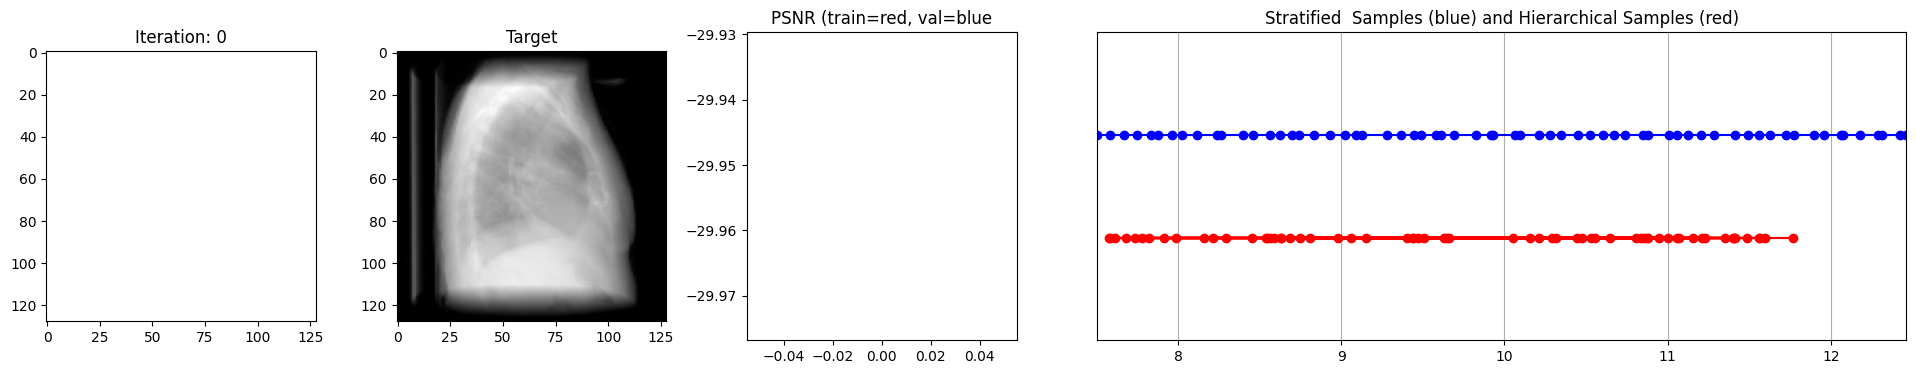

  0%|          | 25/10000 [00:04<21:05,  7.88it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 379.3615417480469


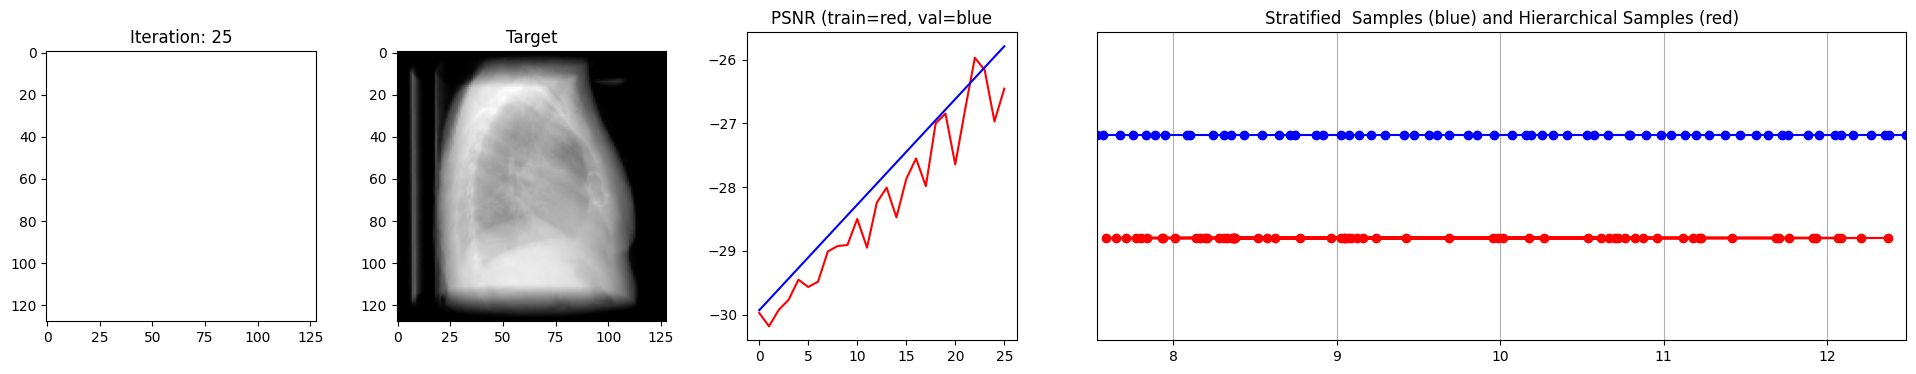

  0%|          | 50/10000 [00:08<21:02,  7.88it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 32.31109619140625


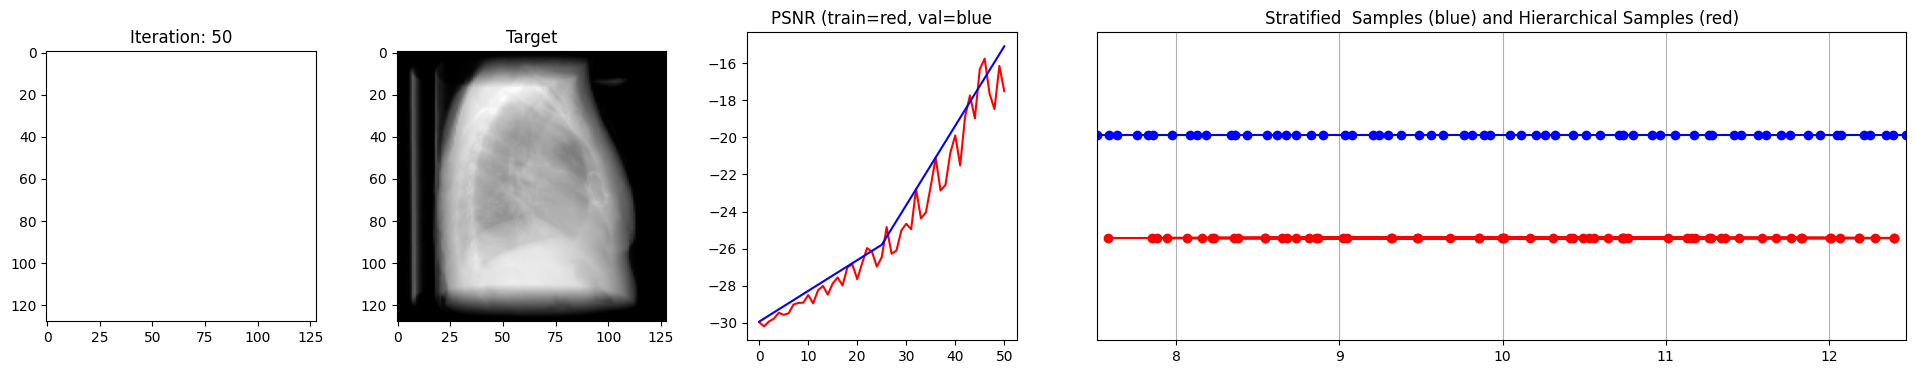

  0%|          | 50/10000 [00:08<29:21,  5.65it/s]


Train PSNR flatlined at -17.515403747558594 for 50 iters. Stopping...


  0%|          | 0/10000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 925.4660034179688


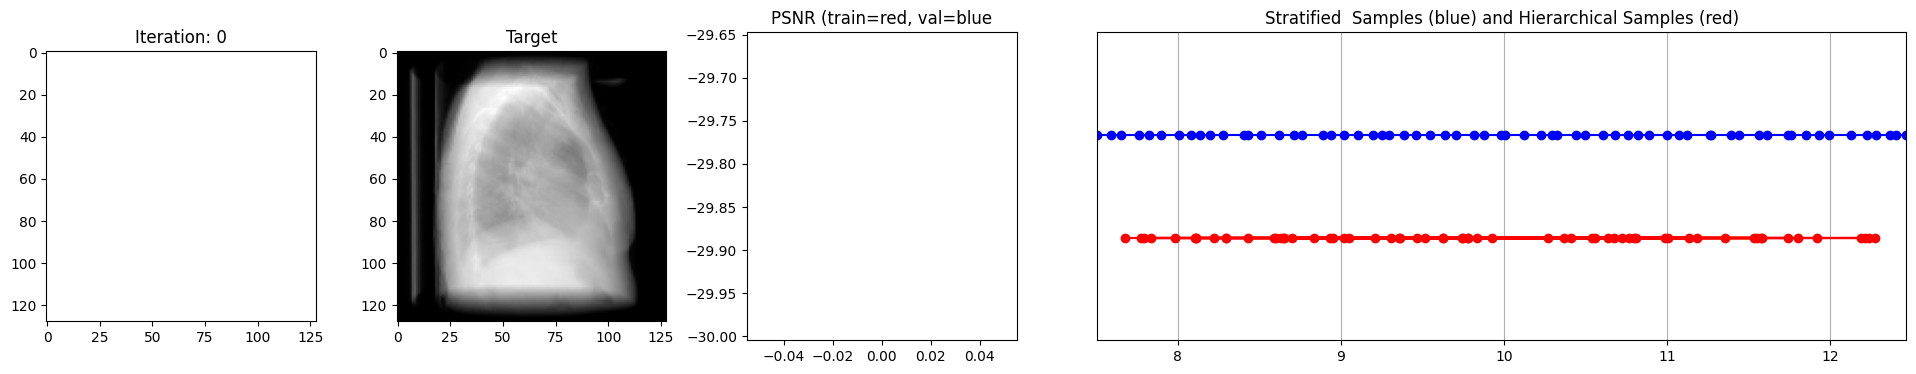

  0%|          | 25/10000 [00:03<21:09,  7.86it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 356.92938232421875


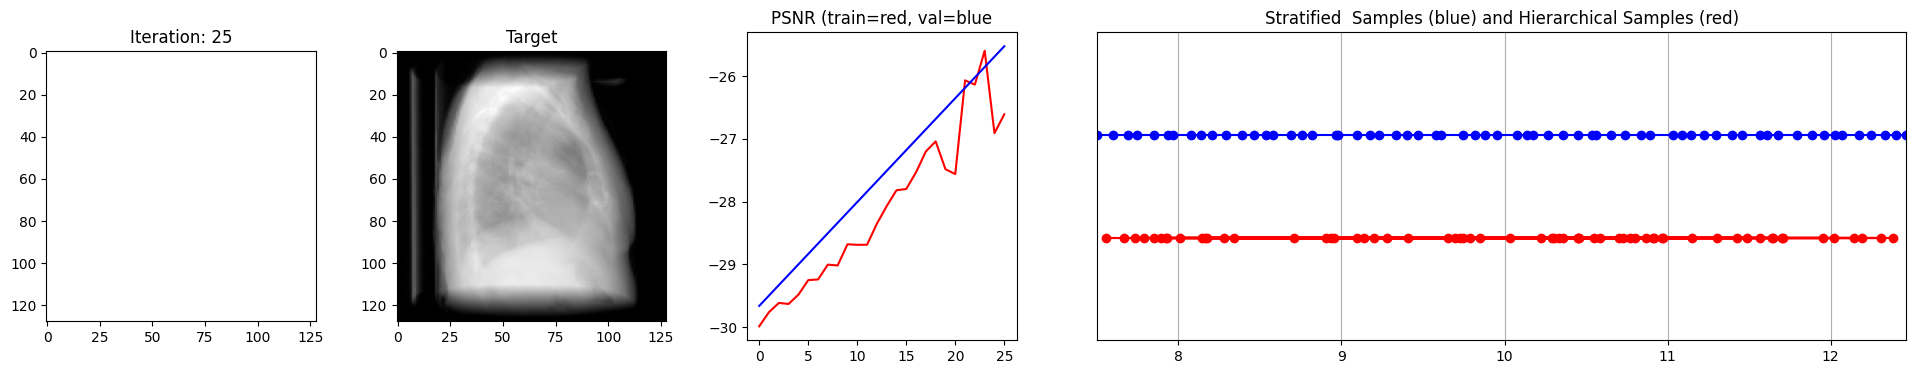

  0%|          | 50/10000 [00:07<21:06,  7.86it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 35.675148010253906


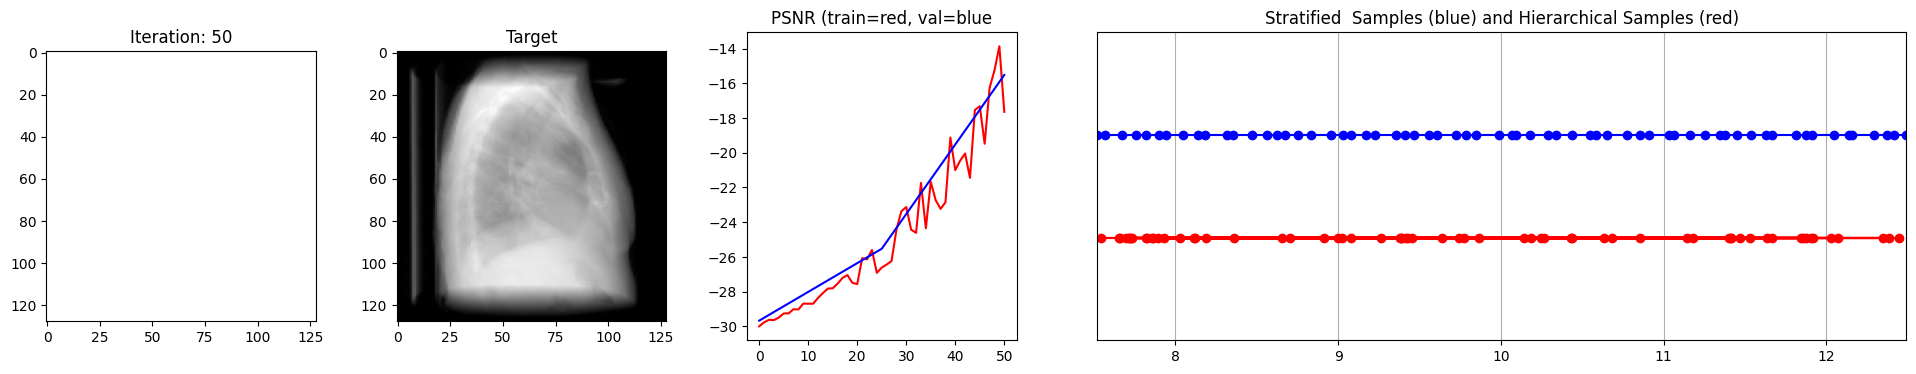

  0%|          | 50/10000 [00:07<25:49,  6.42it/s]


Train PSNR flatlined at -17.64469337463379 for 50 iters. Stopping...


  0%|          | 0/10000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 942.1202392578125


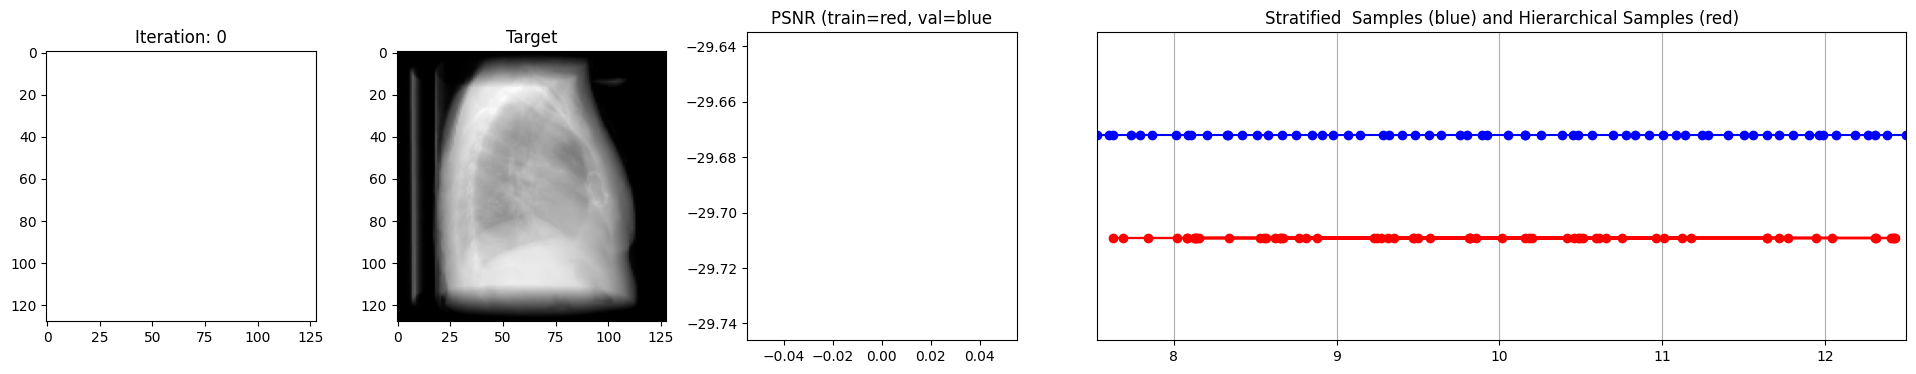

  0%|          | 25/10000 [00:03<21:11,  7.84it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 262.4784240722656


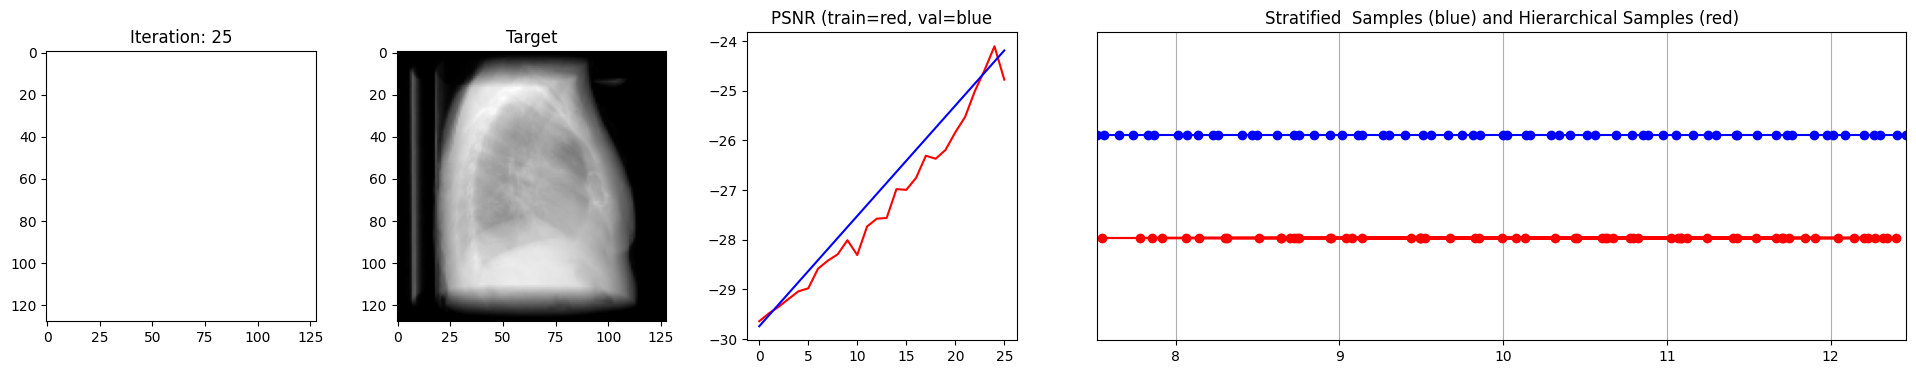

  0%|          | 50/10000 [00:07<21:03,  7.87it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 22.808513641357422


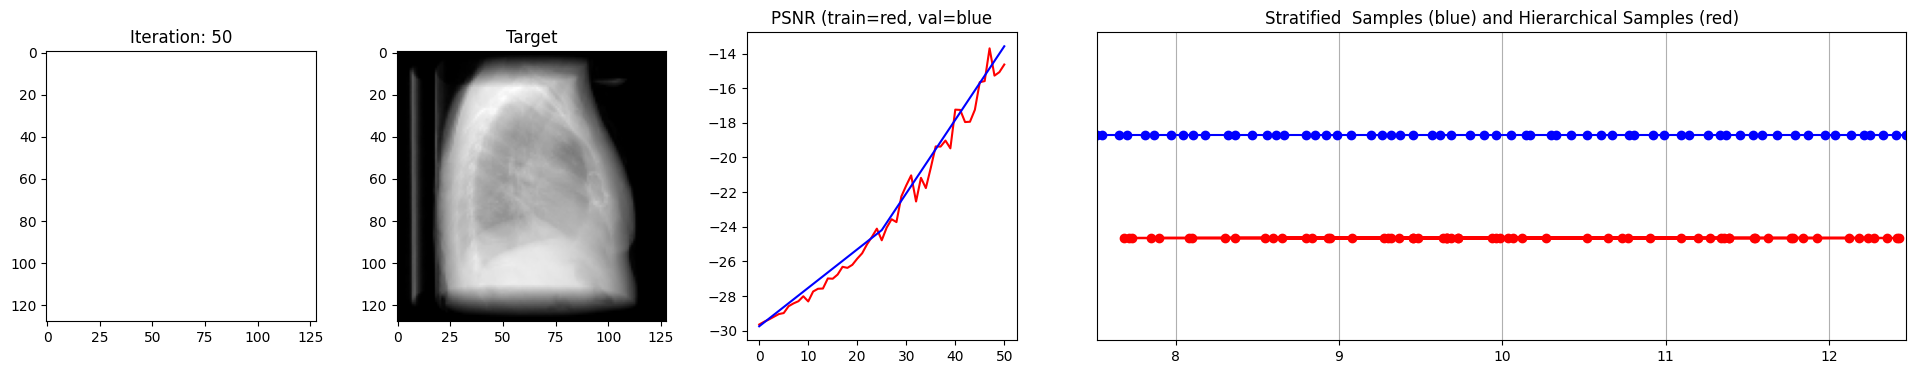

  0%|          | 50/10000 [00:07<25:28,  6.51it/s]


Train PSNR flatlined at -14.634578704833984 for 50 iters. Stopping...


  0%|          | 0/10000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 928.0809326171875


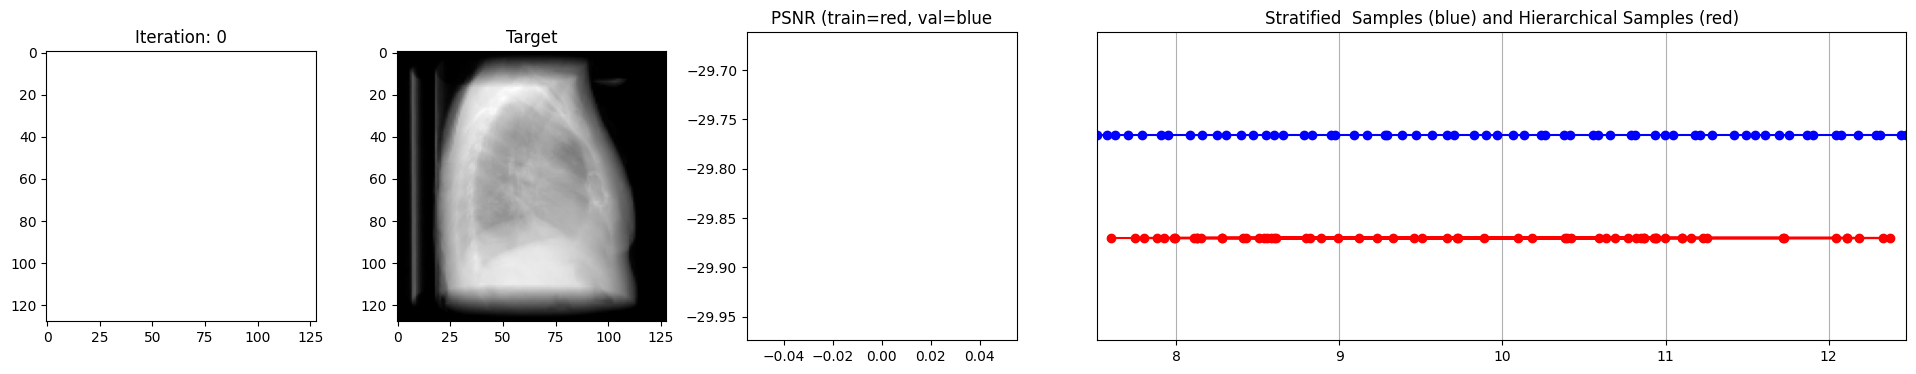

  0%|          | 25/10000 [00:03<21:15,  7.82it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 363.02191162109375


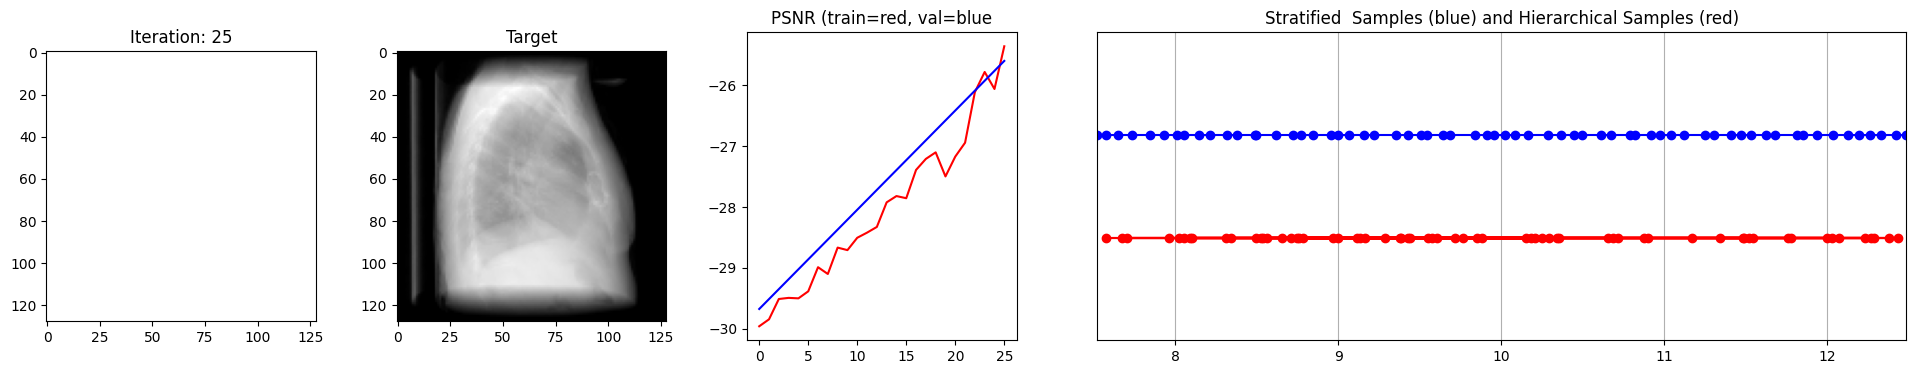

  0%|          | 50/10000 [00:07<21:12,  7.82it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 46.47513961791992


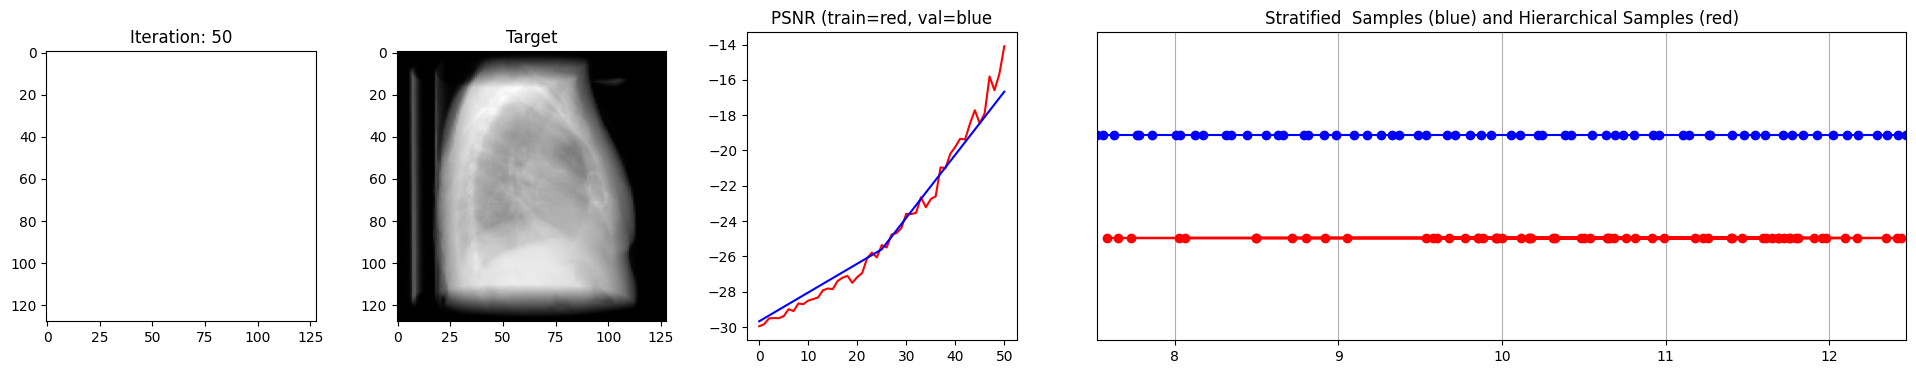

  0%|          | 50/10000 [00:07<25:44,  6.44it/s]


Train PSNR flatlined at -14.097517967224121 for 50 iters. Stopping...


  0%|          | 0/10000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 935.531982421875


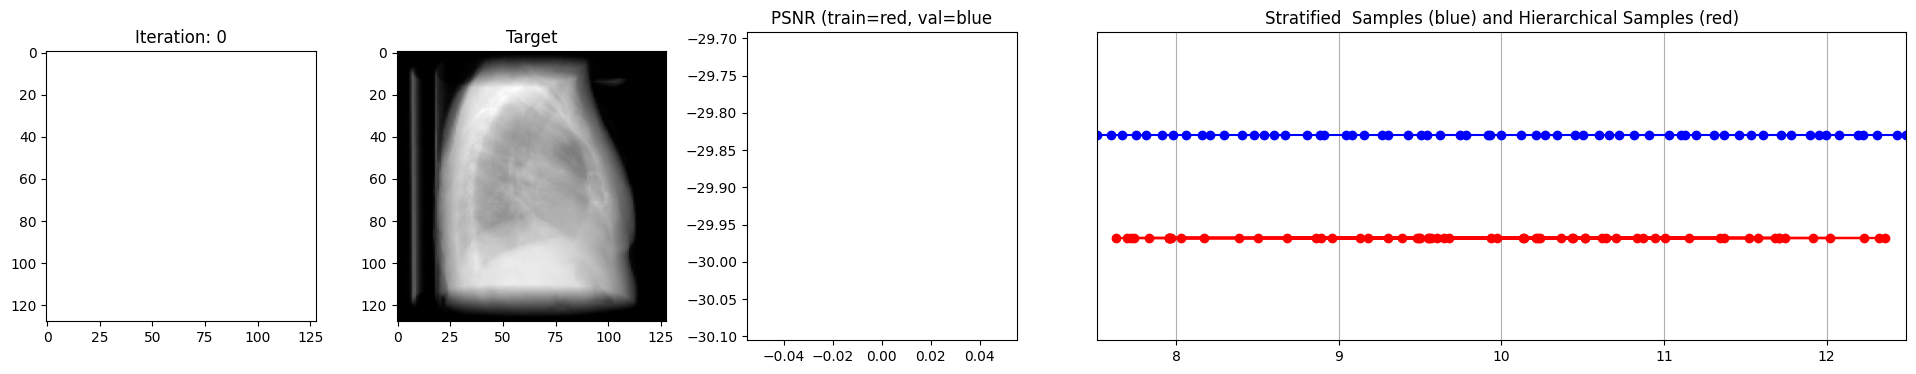

  0%|          | 25/10000 [00:03<21:06,  7.88it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 340.9765625


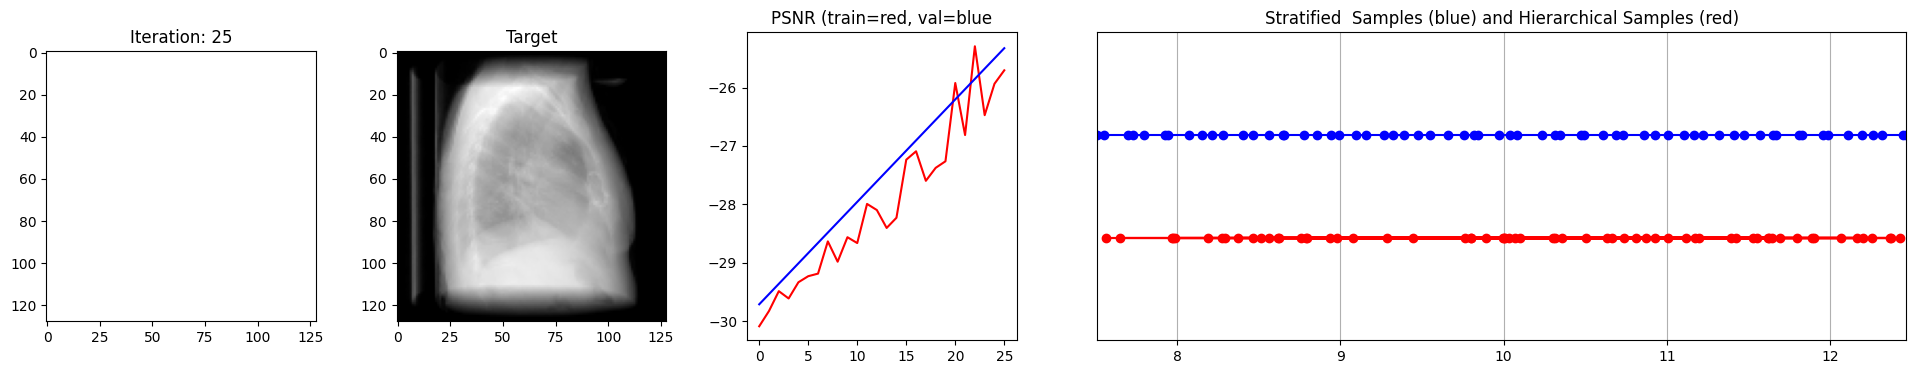

  0%|          | 50/10000 [00:07<20:58,  7.91it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 54.04052734375


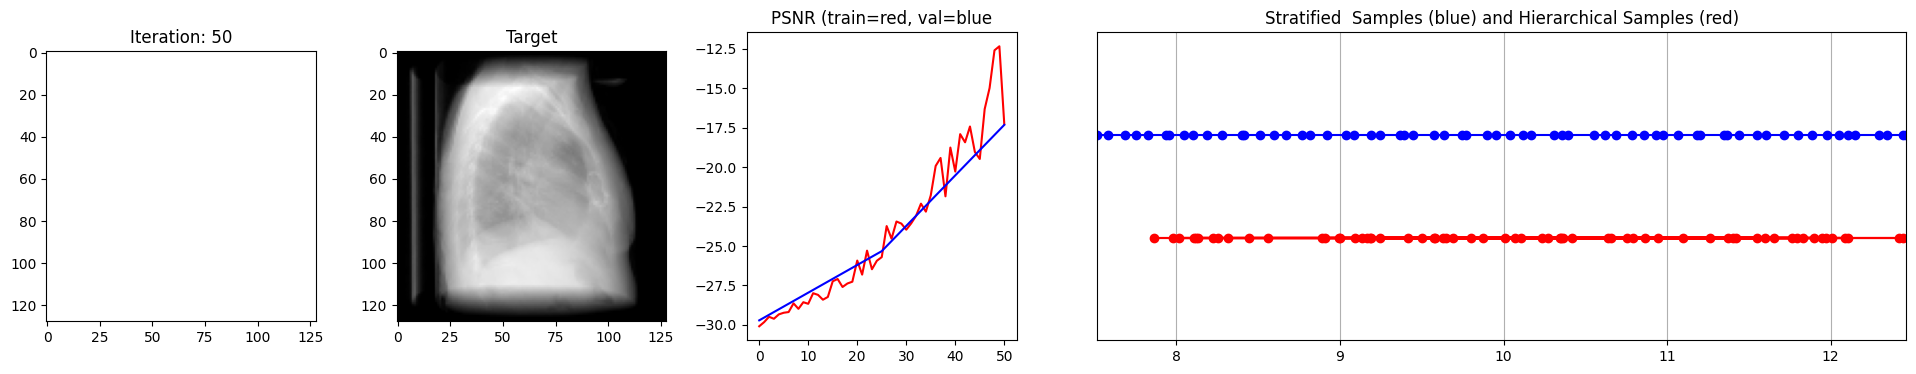

  0%|          | 50/10000 [00:07<25:34,  6.48it/s]


Train PSNR flatlined at -17.275711059570312 for 50 iters. Stopping...


  0%|          | 0/10000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 958.4664916992188


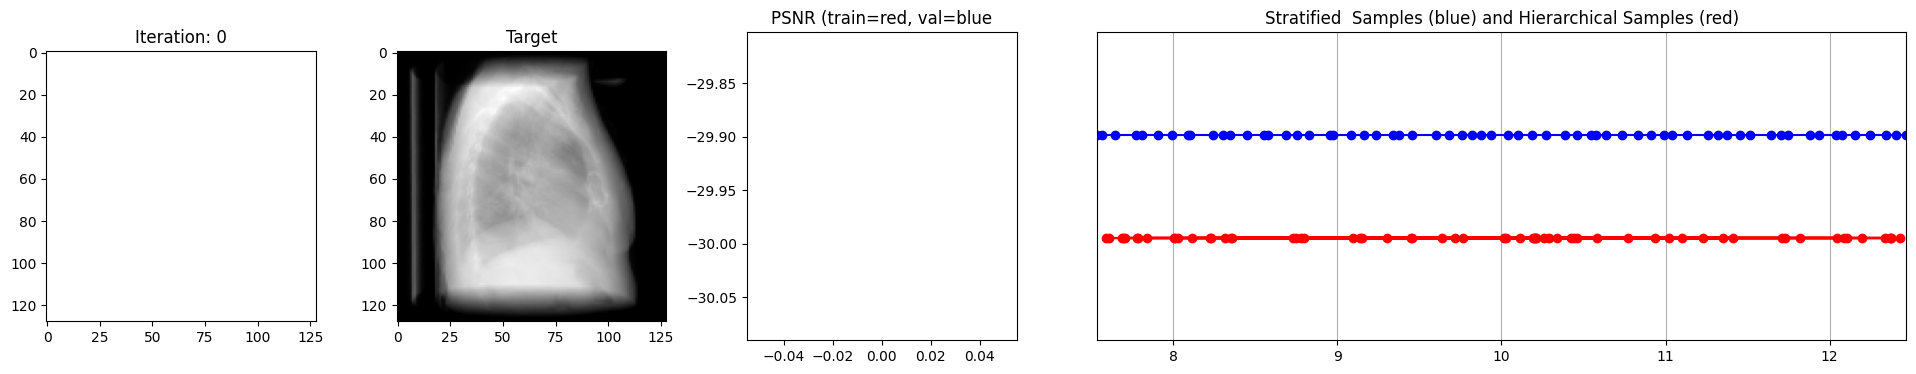

  0%|          | 25/10000 [00:03<21:20,  7.79it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 374.46087646484375


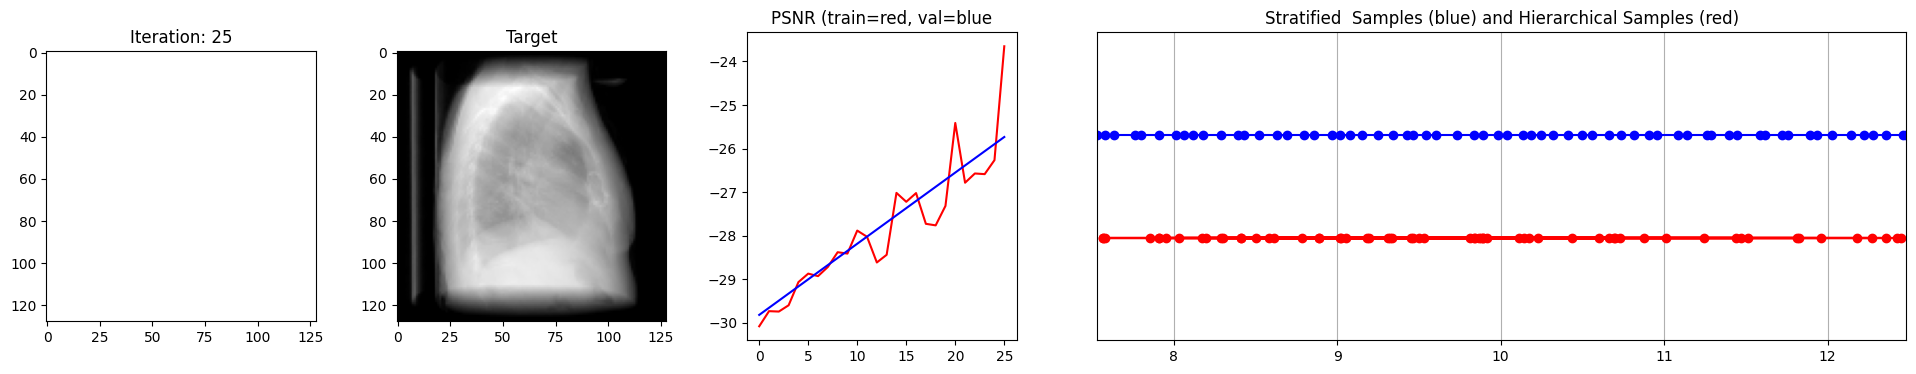

  0%|          | 50/10000 [00:07<21:19,  7.78it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 41.62477111816406


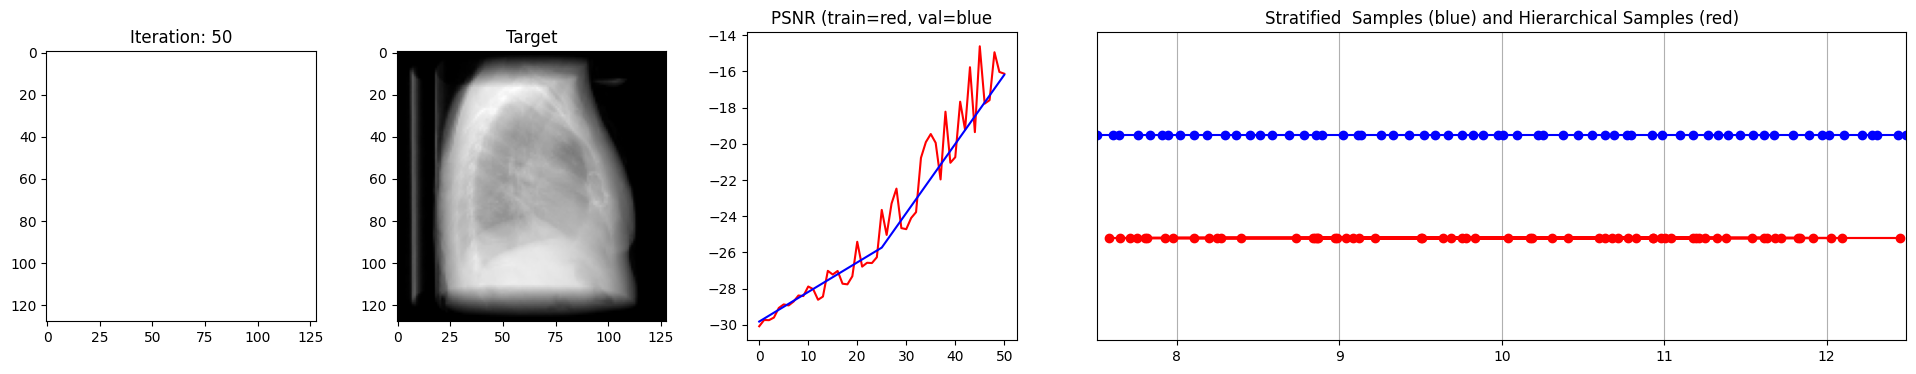

  0%|          | 50/10000 [00:07<25:39,  6.46it/s]


Train PSNR flatlined at -16.132402420043945 for 50 iters. Stopping...


  0%|          | 0/10000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 946.0726928710938


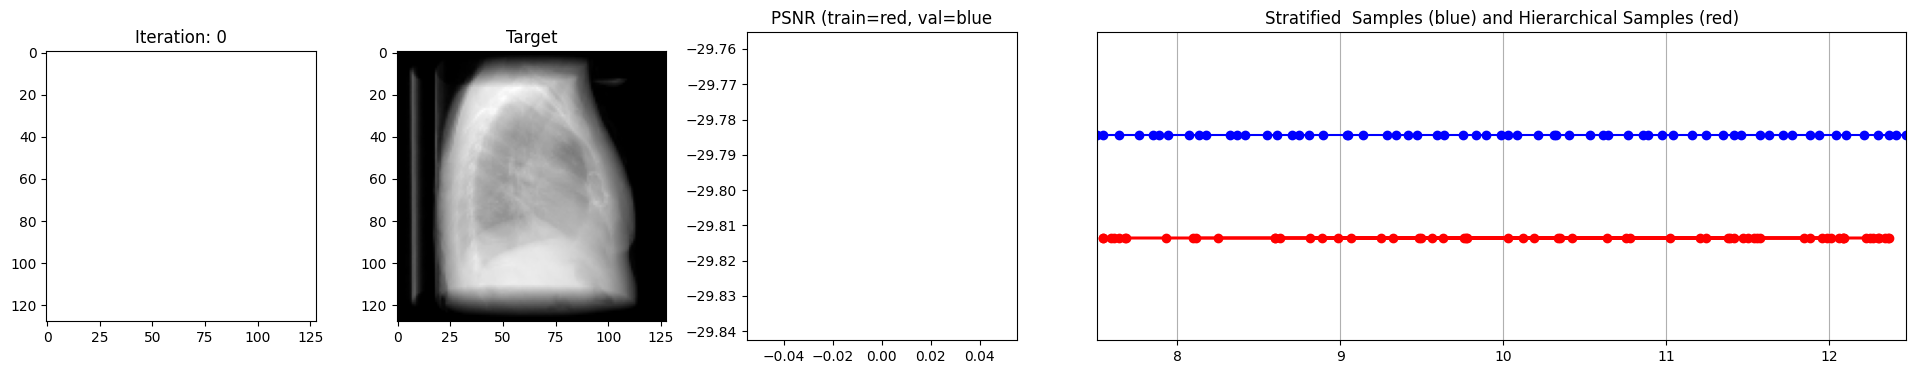

  0%|          | 25/10000 [00:03<21:06,  7.88it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 351.55487060546875


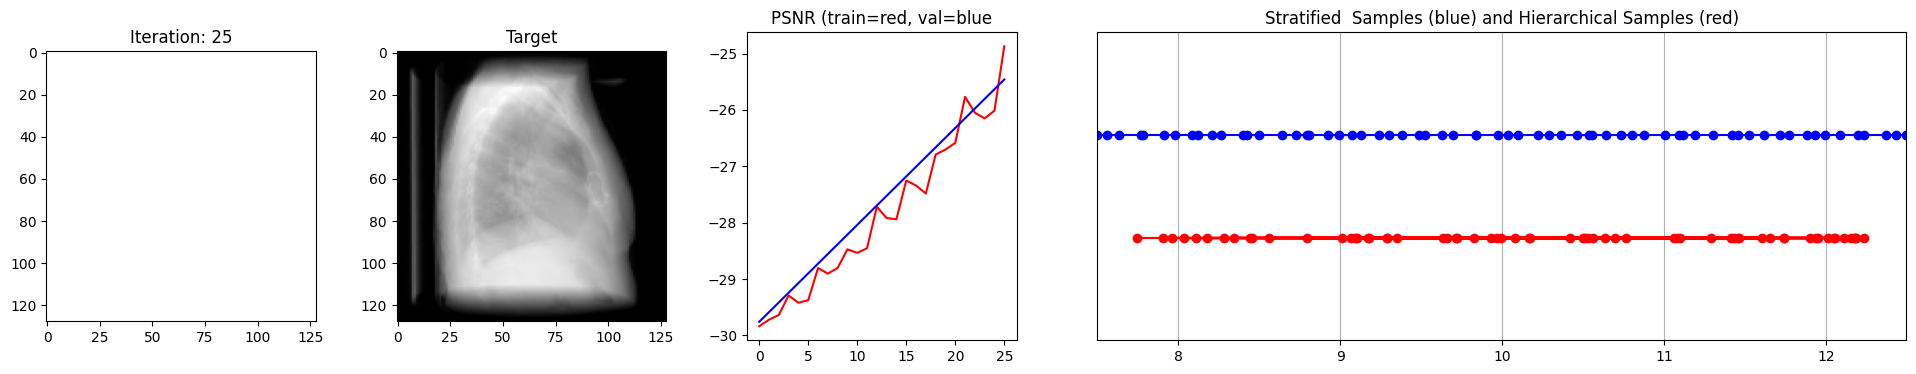

  0%|          | 50/10000 [00:07<21:03,  7.87it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 46.170379638671875


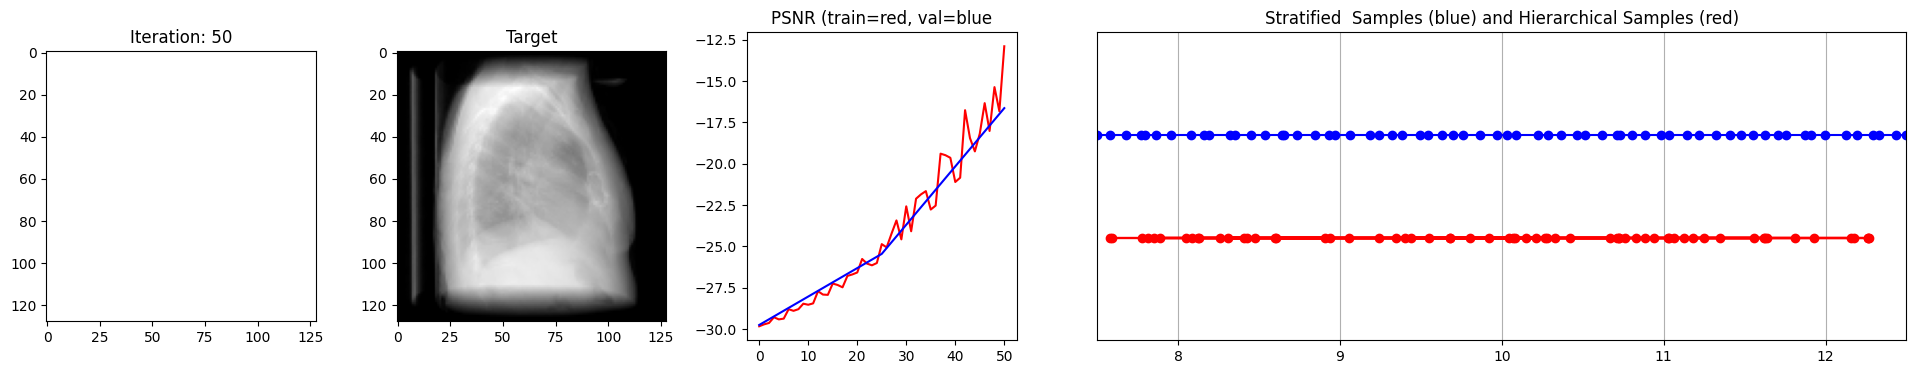

  0%|          | 50/10000 [00:07<25:43,  6.45it/s]


Train PSNR flatlined at -12.902054786682129 for 50 iters. Stopping...


  0%|          | 0/10000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 975.7999267578125


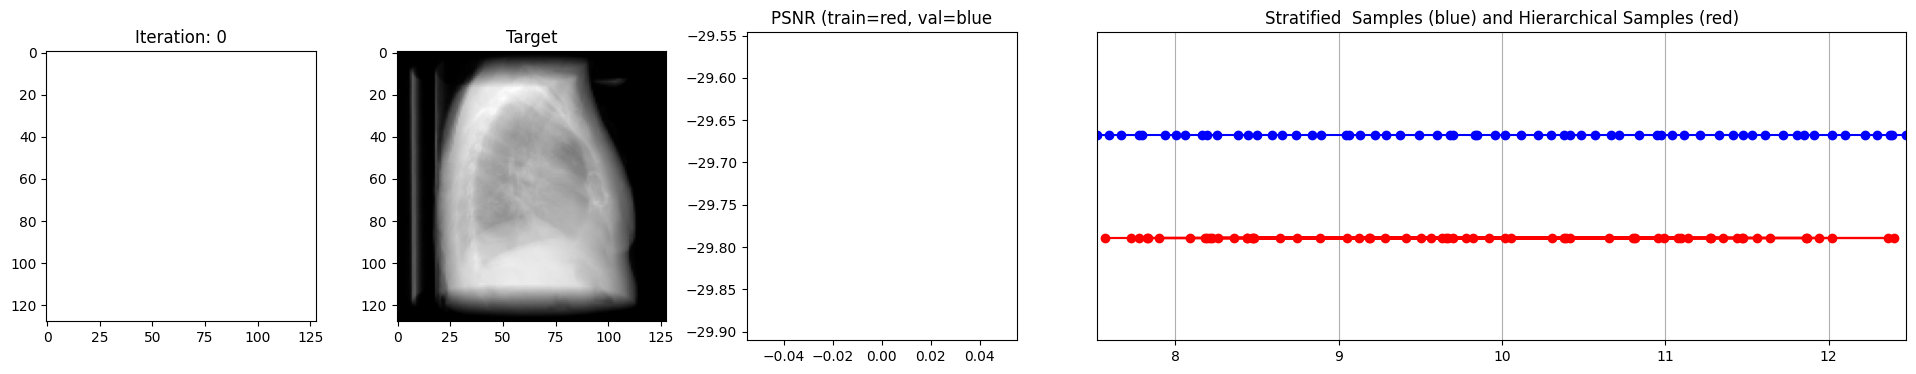

  0%|          | 25/10000 [00:03<21:21,  7.79it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 398.1816101074219


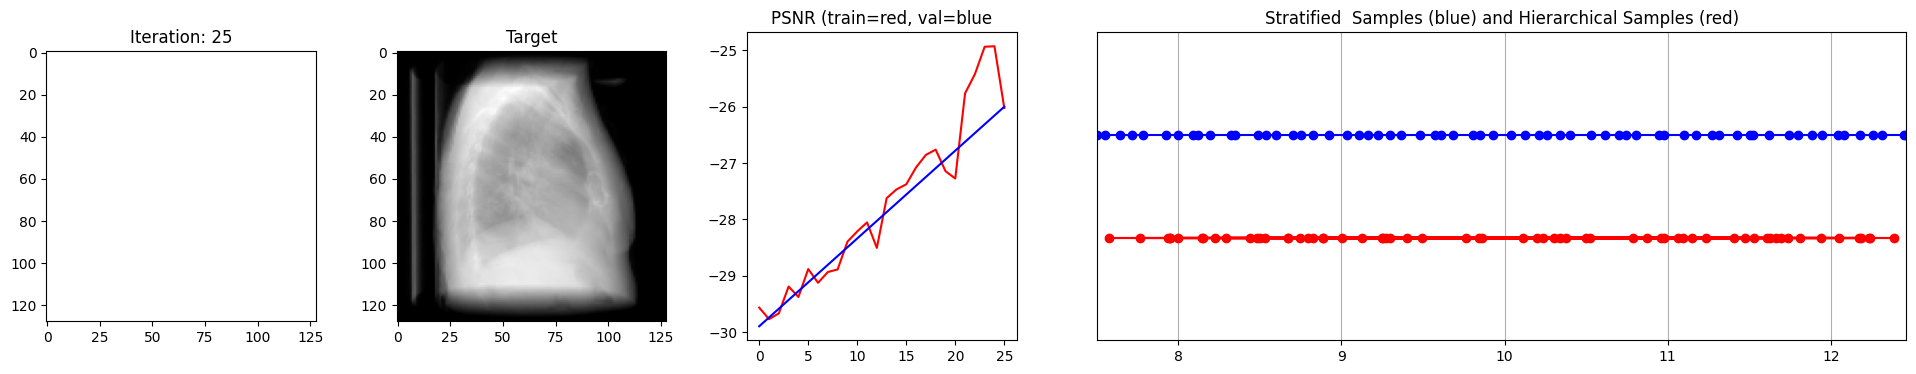

  0%|          | 50/10000 [00:07<21:17,  7.79it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 80.62260437011719


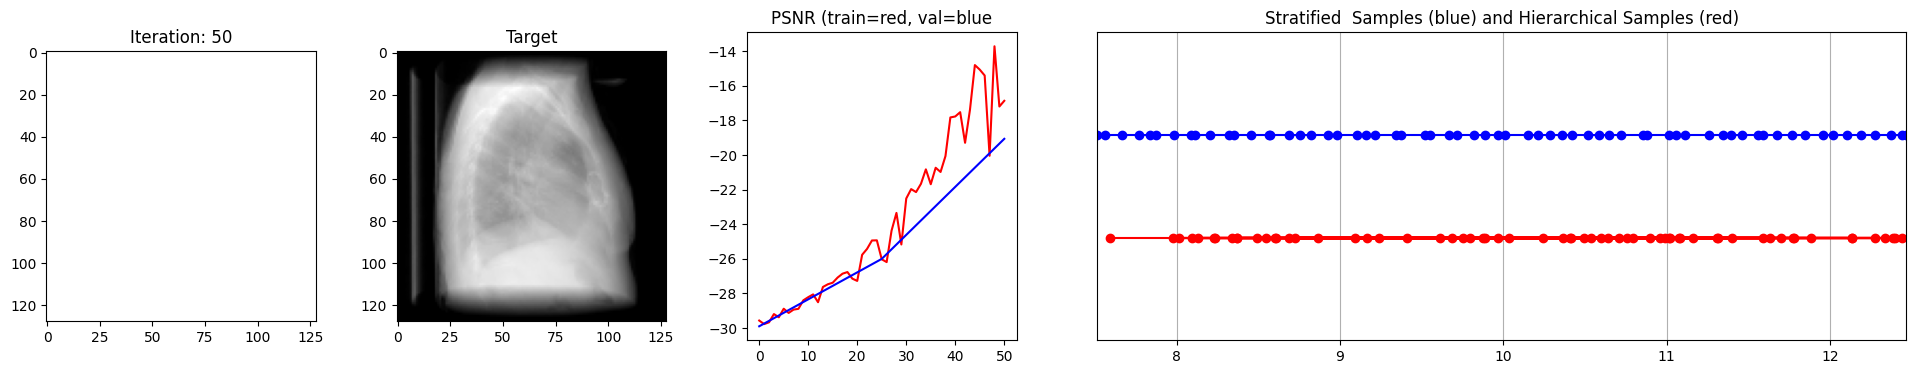

  0%|          | 50/10000 [00:07<25:52,  6.41it/s]


Train PSNR flatlined at -16.868289947509766 for 50 iters. Stopping...


  0%|          | 0/10000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 877.654296875


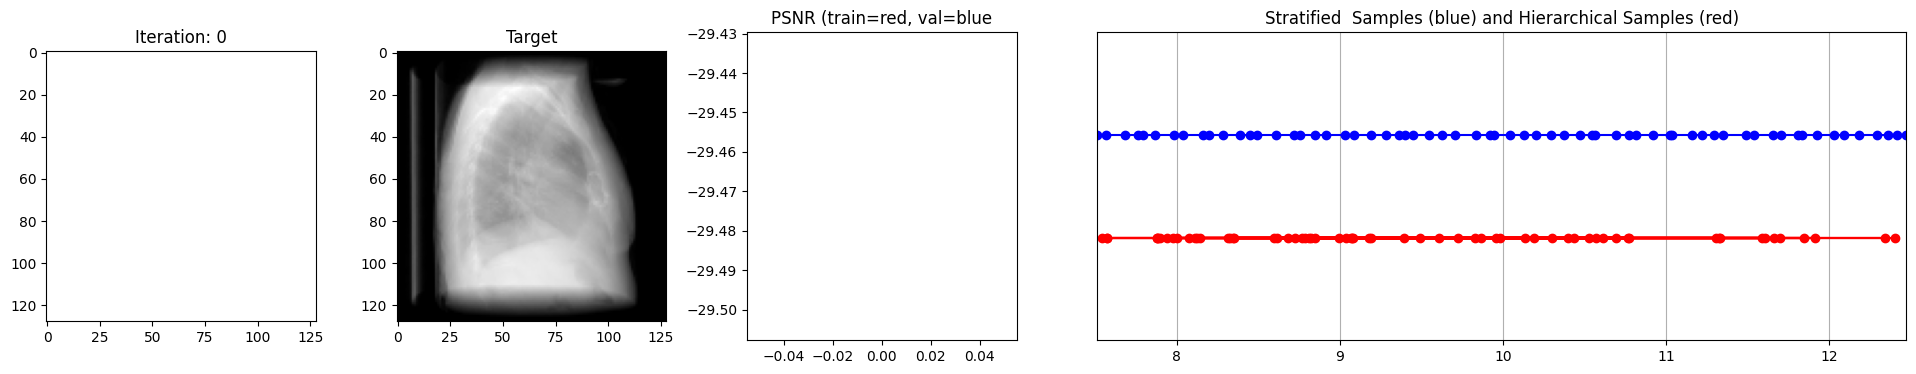

  0%|          | 25/10000 [00:03<21:09,  7.86it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 336.38397216796875


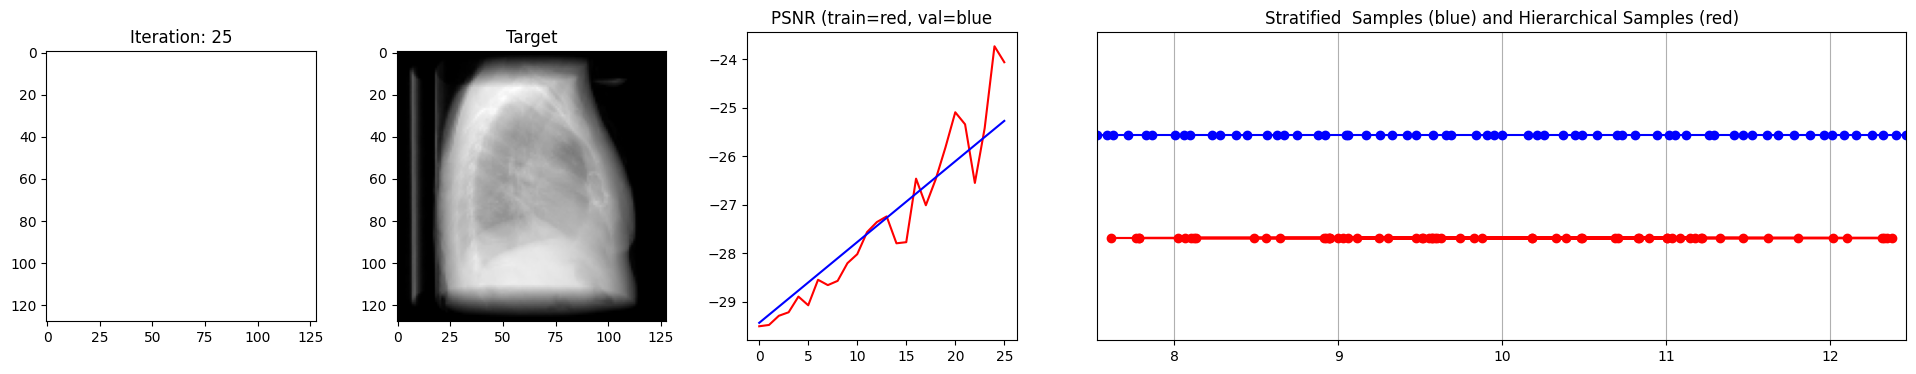

  0%|          | 50/10000 [00:07<21:14,  7.81it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 38.98225021362305


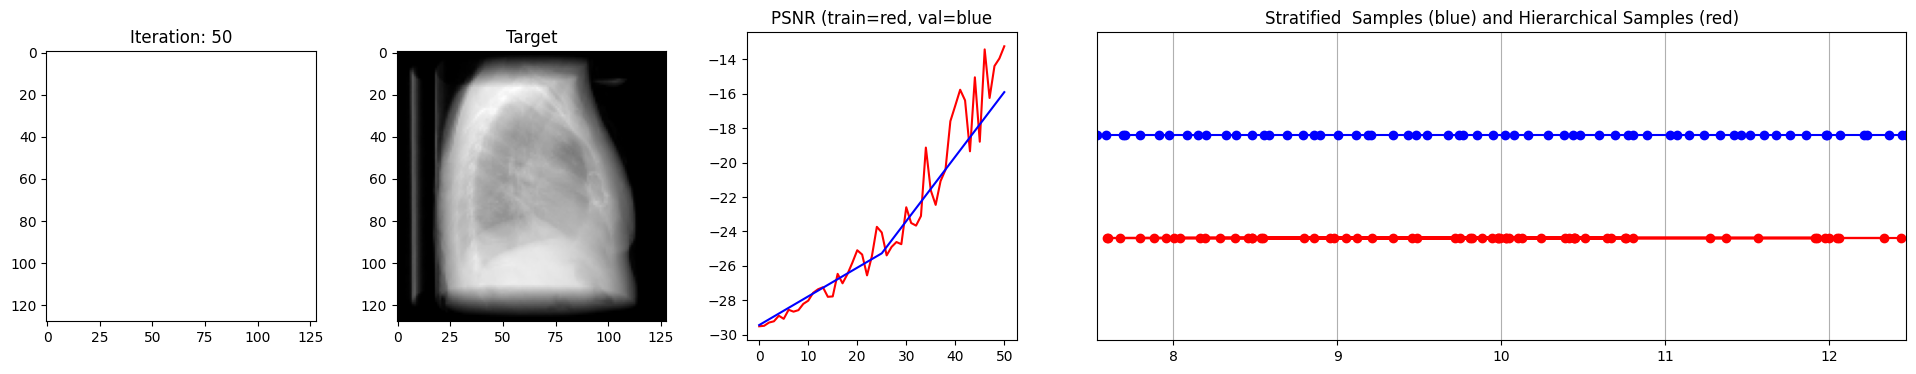

  0%|          | 50/10000 [00:07<25:41,  6.46it/s]


Train PSNR flatlined at -13.24554443359375 for 50 iters. Stopping...


  0%|          | 0/10000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 897.5335693359375


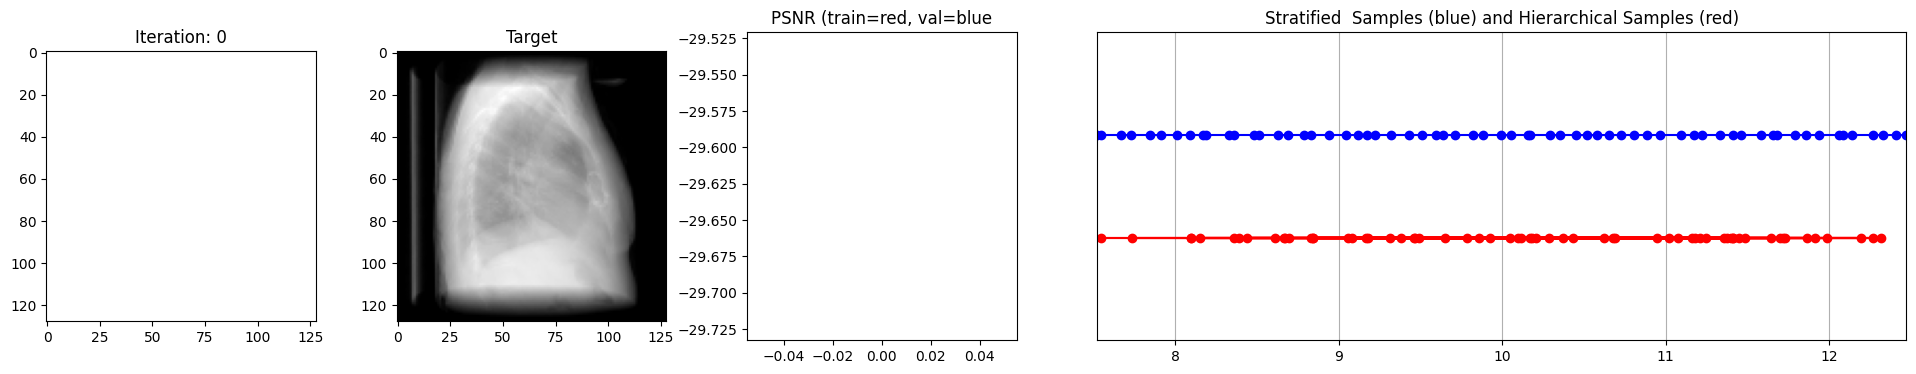

  0%|          | 25/10000 [00:03<21:09,  7.86it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 274.29400634765625


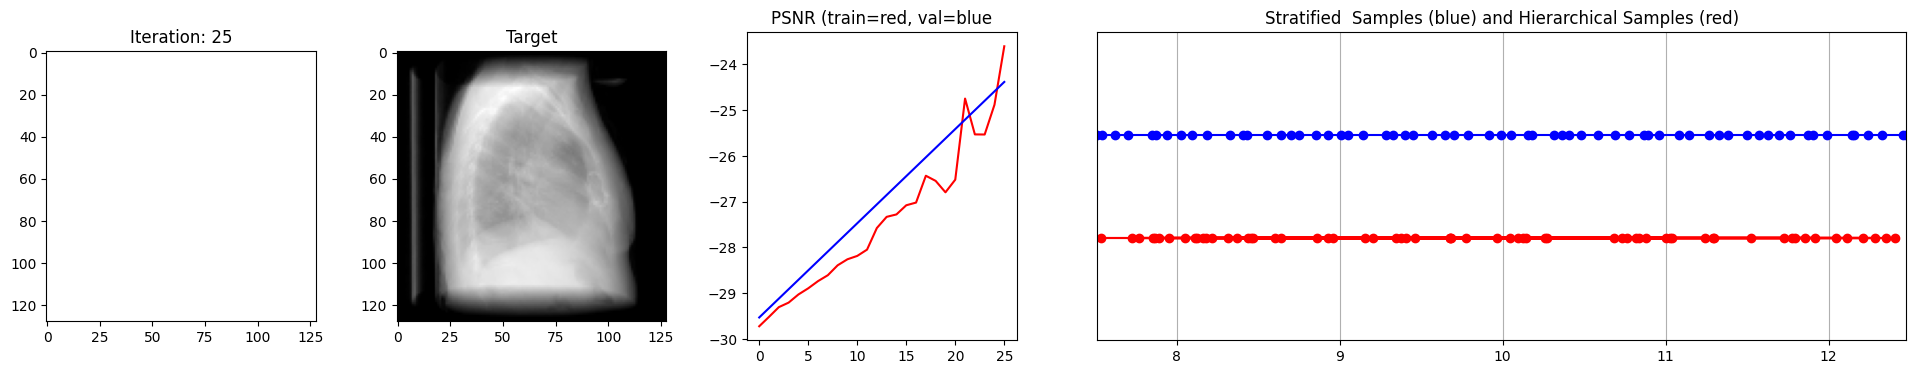

  0%|          | 50/10000 [00:07<21:11,  7.83it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 39.06232452392578


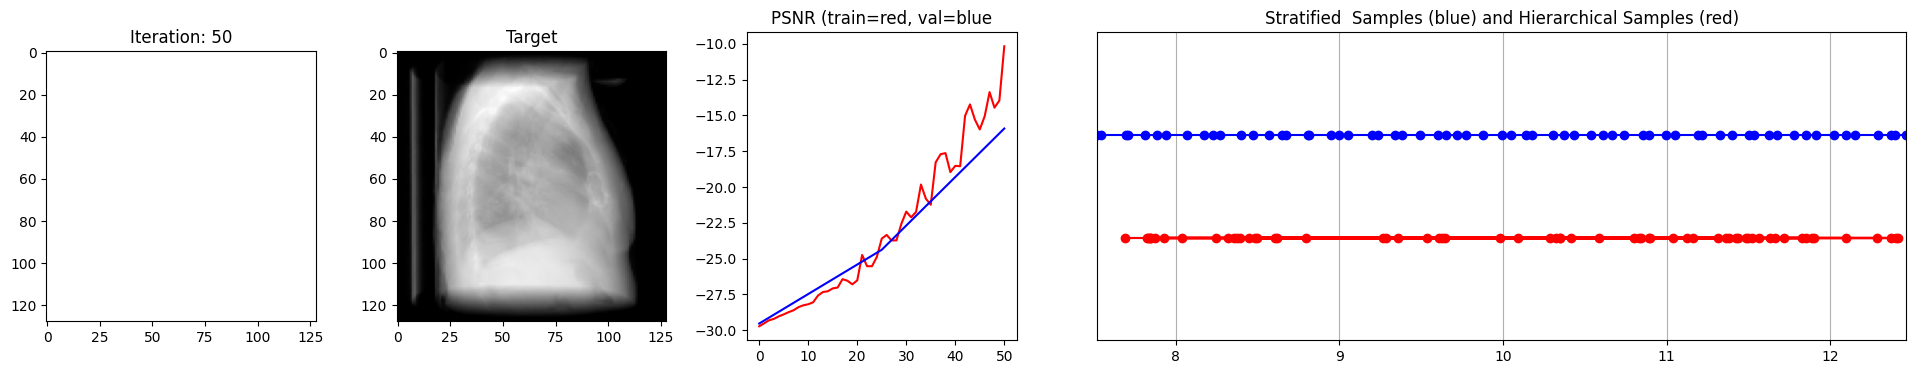

  0%|          | 50/10000 [00:07<25:31,  6.50it/s]

Train PSNR flatlined at -10.174999237060547 for 50 iters. Stopping...

Done!


In [46]:
# Run training session(s)
for _ in range(n_restarts):
  model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper = init_models()
  success, train_psnrs, val_psnrs = train()
  if success and val_psnrs[-1] >= warmup_min_fitness:
    print('Training successful!')
    break

print('')
print(f'Done!')

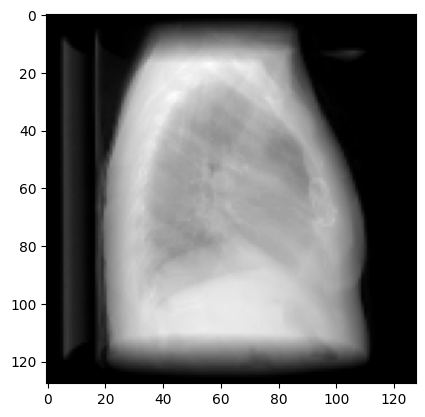

In [19]:
plt.imshow(xray[:,:,0], cmap="gray")